In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

'Colab Notebooks'   Objective1


In [ ]:
import os
dataset_path = "/content/drive/MyDrive/Objective1"
# List main folders
print("Main folders:", os.listdir(dataset_path))

Main folders: ['Flatfield', 'Originals', 'Official', 'Wikipedia', 'Tampered images', 'scanner_model_calibrated.pkl', 'metrics', 'features_enriched.pkl', 'split_dpi_stratified.pkl', 'streamlit_app.py', 'official_wiki_residuals.pkl', 'flatfield_residuals.pkl', 'scanner_fingerprints.pkl', 'dataset_inventory.csv', 'fp_keys.npy', 'cnn_scanner_model.h5', 'cnn_label_encoder.pkl', 'scanner_model.pkl', 'scanner_model_svm.pkl', 'features_ext.pkl', 'scanner_model_balanced.pkl', 'features.pkl', 'best_fixed_cnn_model.h5', 'enhanced_features.pkl', 'pca_visualization.png', 'tsne_visualization.png', 'feature_heatmap.png', 'best_cnn_model.h5', 'label_encoder.pkl', 'scanner_cnn_model.h5', 'cnn_training_curves.png', 'hybrid_label_encoder.pkl', 'hybrid_feat_scaler.pkl', 'scanner_hybrid.keras', 'scanner_hybrid_final.keras', 'hybrid_training_history.pkl', 'artifacts_tamper', 'Originals_tif', 'artifacts', 'manifests', 'artifacts_tamper_fixed', 'artifacts_tamper_patch', 'artifacts_tamper_pair', 'reports']


Milestone 1 — Dataset collection and preprocessing

Mounts Google Drive at /content/drive to access the Objective1 dataset.

Recursively traverses the Objective1 directory and prints each folder name with the count of files directly inside it.

Tracks and accumulates file counts for each top-level category (e.g., Flatfield, Official, Wikipedia, Tampered images).

Prints a hierarchical view with indentation showing subfolders under each main folder.

After traversal, prints a summary table of total files per main folder.

Computes and displays a grand total of all files counted across the Objective1 tree.



EDA on folders

In [ ]:
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive', force_remount=False)

main_counts = {}  # dictionary to store counts per main folder

def print_tree_counts(path, indent="", top_level=None):
    global main_counts
    items = sorted(os.listdir(path))
    file_count = sum([1 for i in items if os.path.isfile(os.path.join(path, i))])
    print(f"{indent}📁 {os.path.basename(path)}/ ({file_count} files)")

    # track counts for top-level main folders
    if top_level is not None:
        main_counts[top_level] = main_counts.get(top_level, 0) + file_count

    for item in items:
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            # pass top_level = current main folder
            if indent == "":  # first level (Flatfield, Official, etc.)
                print_tree_counts(item_path, indent + "    ", top_level=item)
            else:
                print_tree_counts(item_path, indent + "    ", top_level=top_level)

# ---- Run on your dataset ----
dataset_path = "/content/drive/MyDrive/Objective1"
print_tree_counts(dataset_path)

# ---- Print main folder totals ----
print("\n📊 Total files per main folder:")
for folder, count in main_counts.items():
    print(f"   {folder}: {count} files")

print(f"\n✅ Grand Total: {sum(main_counts.values())} files")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Objective1/ (30 files)
    📁 Flatfield/ (0 files)
        📁 Canon120-1/ (2 files)
        📁 Canon120-2/ (2 files)
        📁 Canon220/ (2 files)
        📁 Canon9000-1/ (2 files)
        📁 Canon9000-2/ (2 files)
        📁 EpsonV370-1/ (2 files)
        📁 EpsonV370-2/ (2 files)
        📁 EpsonV39-1/ (3 files)
        📁 EpsonV39-2/ (2 files)
        📁 EpsonV550/ (2 files)
        📁 HP/ (2 files)
    📁 Official/ (0 files)
        📁 Canon120-1/ (0 files)
            📁 150/ (100 files)
            📁 300/ (100 files)
        📁 Canon120-2/ (0 files)
            📁 150/ (100 files)
            📁 300/ (100 files)
        📁 Canon220/ (0 files)
            📁 150/ (100 files)
            📁 300/ (100 files)
        📁 Canon9000-1/ (0 files)
            📁 150/ (100 files)
            📁 300/ (100 files)
        📁 Canon9000-2/ (0 files)
            📁 150/ (100 files)
         

Mounts Google Drive and prepares access to the dataset within /content/drive/MyDrive.

Auto-discovers the Flatfield directory anywhere under MyDrive using a case-insensitive search.

Sets output path to save preprocessed residuals as flatfield_residuals.pkl alongside the Flatfield parent folder.

Imports denoisers (Wiener and wavelet), defaulting to Wiener; installs scikit-image on demand for wavelet.

Defines a preprocessing routine: read image, convert to grayscale, resize to 256×256, normalize to , denoise, and compute residual = image − denoised.

Iterates all scanners and valid image files in Flatfield, skips hidden/metadata files (e.g., ._), and accumulates residuals per scanner.

Saves a dictionary {scanner: [residual arrays]} to flatfield_residuals.pkl for downstream fingerprint extraction.

Prints a summary showing how many scanners and images were successfully processed, plus example scanner keys.

In [ ]:
# ==============================
# STEP 2A: Preprocess Flatfield -> Save residuals (flatfield_residuals.pkl)
# ==============================

# 0) Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, pickle, cv2, numpy as np
from tqdm import tqdm

# ---------------------------
# 1) Auto-locate Flatfield folder
# ---------------------------
def find_flatfield(base="/content/drive/MyDrive"):
    found = []
    for root, dirs, files in os.walk(base):
        for d in dirs:
            if d.lower() == "flatfield":   # case-insensitive search
                found.append(os.path.join(root, d))
    return found

flatfield_paths = find_flatfield("/content/drive/MyDrive")
if not flatfield_paths:
    raise FileNotFoundError("❌ No 'Flatfield' folder found in your Drive. Please check dataset upload.")
else:
    FLATFIELD_DIR = flatfield_paths[0]  # take the first match
    BASE = os.path.dirname(FLATFIELD_DIR)
    OUTPUT_PKL = os.path.join(BASE, "flatfield_residuals.pkl")
    print("✅ Found Flatfield folder:", FLATFIELD_DIR)
    print("Will save residuals to:", OUTPUT_PKL)

# ---------------------------
# 2) Import denoising filters
# ---------------------------
try:
    from skimage.restoration import denoise_wavelet
except Exception:
    !pip install scikit-image
    from skimage.restoration import denoise_wavelet

from scipy.signal import wiener as scipy_wiener

# ---------------------------
# 3) Parameters
# ---------------------------
IMG_SIZE = (256, 256)      # resize target
DENOISE_METHOD = "wavelet"  # "wiener" or "wavelet"

# ---------------------------
# 4) Preprocess function
# ---------------------------
def preprocess_image_residual(path, img_size=IMG_SIZE, method="wiener"):
    """Read image -> grayscale -> resize -> normalize -> denoise -> return residual."""
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    if method == "wiener":
        den = scipy_wiener(img, mysize=(5,5))
    else:
        den = denoise_wavelet(img, channel_axis=None, rescale_sigma=True)
    return (img - den).astype(np.float32)

# ---------------------------
# 5) Process all Flatfield images
# ---------------------------
flatfield_residuals = {}
scanners = sorted(os.listdir(FLATFIELD_DIR))

for scanner in tqdm(scanners, desc="Scanners"):
    scanner_dir = os.path.join(FLATFIELD_DIR, scanner)
    if not os.path.isdir(scanner_dir):
        continue

    residuals = []
    for fname in sorted(os.listdir(scanner_dir)):
        if fname.startswith("._"):
            continue
        if not fname.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg")):
            continue
        fpath = os.path.join(scanner_dir, fname)
        try:
            res = preprocess_image_residual(fpath, IMG_SIZE, DENOISE_METHOD)
            if res is not None:
                residuals.append(res)
        except Exception as e:
            print(f"⚠️ Failed on {fpath}: {e}")

    if residuals:
        flatfield_residuals[scanner] = residuals
    else:
        print(f"⚠️ No valid images for scanner: {scanner}")

# ---------------------------
# 6) Save results
# ---------------------------
with open(OUTPUT_PKL, "wb") as f:
    pickle.dump(flatfield_residuals, f)

# ---------------------------
# 7) Summary
# ---------------------------
total_scanners = len(flatfield_residuals)
total_images = sum(len(v) for v in flatfield_residuals.values())
print(f"\n✅ Done. Saved residuals for {total_scanners} scanners, {total_images} images.")
print("Example scanners:", list(flatfield_residuals.keys())[:5])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found Flatfield folder: /content/drive/MyDrive/Objective1/Flatfield
Will save residuals to: /content/drive/MyDrive/Objective1/flatfield_residuals.pkl


Scanners: 100%|██████████| 11/11 [00:51<00:00,  4.69s/it]


✅ Done. Saved residuals for 11 scanners, 22 images.
Example scanners: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2']


Defines a fast residual-preprocessing pipeline for Official and Wikipedia datasets using grayscale, 256×256 resize, normalization, and Haar wavelet denoising.

Implements denoise_wavelet by zeroing DWT detail coefficients (cH, cV, cD) and reconstructing, then computes residual = image − denoised.

Processes data hierarchically by scanner and DPI (150, 300), preserving structure in an output dictionary.

Uses ThreadPoolExecutor to parallelize per-file preprocessing for speed on Colab.

Filters valid image extensions (.tif, .tiff, .jpg, .jpeg, .png) and skips non-directories safely.

Saves all residuals into official_wiki_residuals.pkl with separate entries for Official and Wikipedia and for each scanner/DPI.



In [ ]:
# ==============================
# STEP 2B: Faster Preprocessing (Official + Wikipedia, with Parallelization)
# ==============================
import os, cv2, numpy as np, pickle
from tqdm import tqdm
import pywt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Paths
OFFICIAL_DIR = "/content/drive/MyDrive/Objective1/Official"
WIKI_DIR = "/content/drive/MyDrive/Objective1/Wikipedia"
OUT_PATH = "/content/drive/MyDrive/Objective1/official_wiki_residuals.pkl"

# ---------------------------
# Preprocessing helpers
# ---------------------------
def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

def resize_to(img, size=(256,256)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize_img(img):
    return img.astype(np.float32) / 255.0

def denoise_wavelet(img):
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs
    # Zero out detail coefficients for denoising
    cH[:] = 0; cV[:] = 0; cD[:] = 0
    return pywt.idwt2((cA,(cH,cV,cD)), 'haar')

def compute_residual(img):
    denoised = denoise_wavelet(img)
    return img - denoised

def process_single_image(fpath):
    """Preprocess one image and return residual"""
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    if img is None:
        return None
    gray = to_gray(img)
    gray = resize_to(gray, (256,256))
    gray = normalize_img(gray)
    return compute_residual(gray)

# ---------------------------
# Dataset Processing
# ---------------------------
def process_dataset(base_dir, dataset_name, residuals_dict):
    print(f"🔄 Preprocessing {dataset_name} images...")

    for scanner in tqdm(os.listdir(base_dir)):
        scanner_path = os.path.join(base_dir, scanner)
        if not os.path.isdir(scanner_path):
            continue

        residuals_dict[dataset_name][scanner] = {}

        for dpi in os.listdir(scanner_path):   # 150, 300
            dpi_path = os.path.join(scanner_path, dpi)
            if not os.path.isdir(dpi_path):
                continue

            files = [os.path.join(dpi_path, f) for f in os.listdir(dpi_path)
                     if f.lower().endswith(('.tif','.tiff','.jpg','.jpeg','.png'))]

            dpi_residuals = []
            # Parallel processing
            with ThreadPoolExecutor(max_workers=8) as executor:  # adjust workers based on Colab
                futures = [executor.submit(process_single_image, f) for f in files]
                for fut in as_completed(futures):
                    res = fut.result()
                    if res is not None:
                        dpi_residuals.append(res)

            residuals_dict[dataset_name][scanner][dpi] = dpi_residuals

# ---------------------------
# Main Execution
# ---------------------------
residuals_dict = {"Official": {}, "Wikipedia": {}}

process_dataset(OFFICIAL_DIR, "Official", residuals_dict)
process_dataset(WIKI_DIR, "Wikipedia", residuals_dict)

with open(OUT_PATH, "wb") as f:
    pickle.dump(residuals_dict, f)

print(f"✅ Saved Official+Wiki residuals (150 & 300 separately) to {OUT_PATH}")


🔄 Preprocessing Official images...


100%|██████████| 11/11 [10:27<00:00, 57.08s/it]


🔄 Preprocessing Wikipedia images...


100%|██████████| 11/11 [10:58<00:00, 59.87s/it]


✅ Saved Official+Wiki residuals (150 & 300 separately) to /content/drive/MyDrive/Objective1/official_wiki_residuals.pkl


Scans Official and Wikipedia roots, walking scanner and DPI subfolders to enumerate all images.

Filters files by common image extensions (.tif, .tiff, .png, .jpg, .jpeg) before recording entries.

Builds a rows list with four columns per image: dataset, scanner, dpi, and absolute file path.

Writes a CSV header and all rows to dataset_inventory.csv under Objective1.

Ensures the output directory exists and prints the save path plus total row count for verification.



In [ ]:
# ==============================
# INSERT A: Dataset inventory CSV (after Step 2B)
# ==============================
import os, csv

roots = [
  ("/content/drive/MyDrive/Objective1/Official", "Official"),
  ("/content/drive/MyDrive/Objective1/Wikipedia", "Wikipedia"),
]
rows = []
for root, ds in roots:
    if not os.path.isdir(root):
        continue
    for scanner in sorted(os.listdir(root)):
        sp = os.path.join(root, scanner)
        if not os.path.isdir(sp):
            continue
        for dpi in sorted(os.listdir(sp)):
            dp = os.path.join(sp, dpi)
            if not os.path.isdir(dp):
                continue
            for f in sorted(os.listdir(dp)):
                if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg')):
                    rows.append([ds, scanner, dpi, os.path.join(dp,f)])

out_csv = "/content/drive/MyDrive/Objective1/dataset_inventory.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
with open(out_csv, "w", newline="") as fh:
    w = csv.writer(fh)
    w.writerow(["dataset","scanner","dpi","path"])
    w.writerows(rows)

print("Wrote inventory:", out_csv, "| rows:", len(rows))


Wrote inventory: /content/drive/MyDrive/Objective1/dataset_inventory.csv | rows: 4568


Loads precomputed Flatfield residuals from flatfield_residuals.pkl.

Computes a per-scanner fingerprint by averaging residual images to capture stable scanner-specific noise.

Stores all fingerprints in scanner_fingerprints.pkl for reuse in feature extraction and inference.

Creates a deterministic, sorted list of scanner keys (fp_keys) and saves it to fp_keys.npy.

Uses the saved key order later to ensure feature vectors align consistently across training and inference.



**Milestone 2 — Feature engineering and baselines**

In [ ]:
# ==============================
# STEP 3: Fingerprint Extraction (from Flatfields) + Save stable order
# ==============================
import pickle, numpy as np

# Paths
FLATFIELD_RESIDUALS_PATH = "/content/drive/MyDrive/Objective1/flatfield_residuals.pkl"  # from Step 2A
FP_OUT_PATH = "/content/drive/MyDrive/Objective1/scanner_fingerprints.pkl"
ORDER_NPY   = "/content/drive/MyDrive/Objective1/fp_keys.npy"

# ---------------------------
# Load residuals
# ---------------------------
with open(FLATFIELD_RESIDUALS_PATH, "rb") as f:
    flatfield_residuals = pickle.load(f)

# ---------------------------
# Compute fingerprint per scanner
# ---------------------------
scanner_fingerprints = {}
print("🔄 Computing fingerprints from Flatfields...")
for scanner, residuals in flatfield_residuals.items():
    if not residuals:
        continue
    stack = np.stack(residuals, axis=0)       # (num_images, H, W)
    fingerprint = np.mean(stack, axis=0)      # average residual
    scanner_fingerprints[scanner] = fingerprint

print(f"✅ Extracted {len(scanner_fingerprints)} scanner fingerprints.")

# ---------------------------
# Save fingerprints
# ---------------------------
with open(FP_OUT_PATH, "wb") as f:
    pickle.dump(scanner_fingerprints, f)
print(f"✅ Saved scanner fingerprints to {FP_OUT_PATH}")

# ---------------------------
# Save a stable, deterministic order for scanners
# ---------------------------
fp_keys = sorted(scanner_fingerprints.keys())
np.save(ORDER_NPY, np.array(fp_keys))
print("✅ Saved fp_keys.npy with order:", fp_keys)


🔄 Computing fingerprints from Flatfields...
✅ Extracted 11 scanner fingerprints.
✅ Saved scanner fingerprints to /content/drive/MyDrive/Objective1/scanner_fingerprints.pkl
✅ Saved fp_keys.npy with order: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']


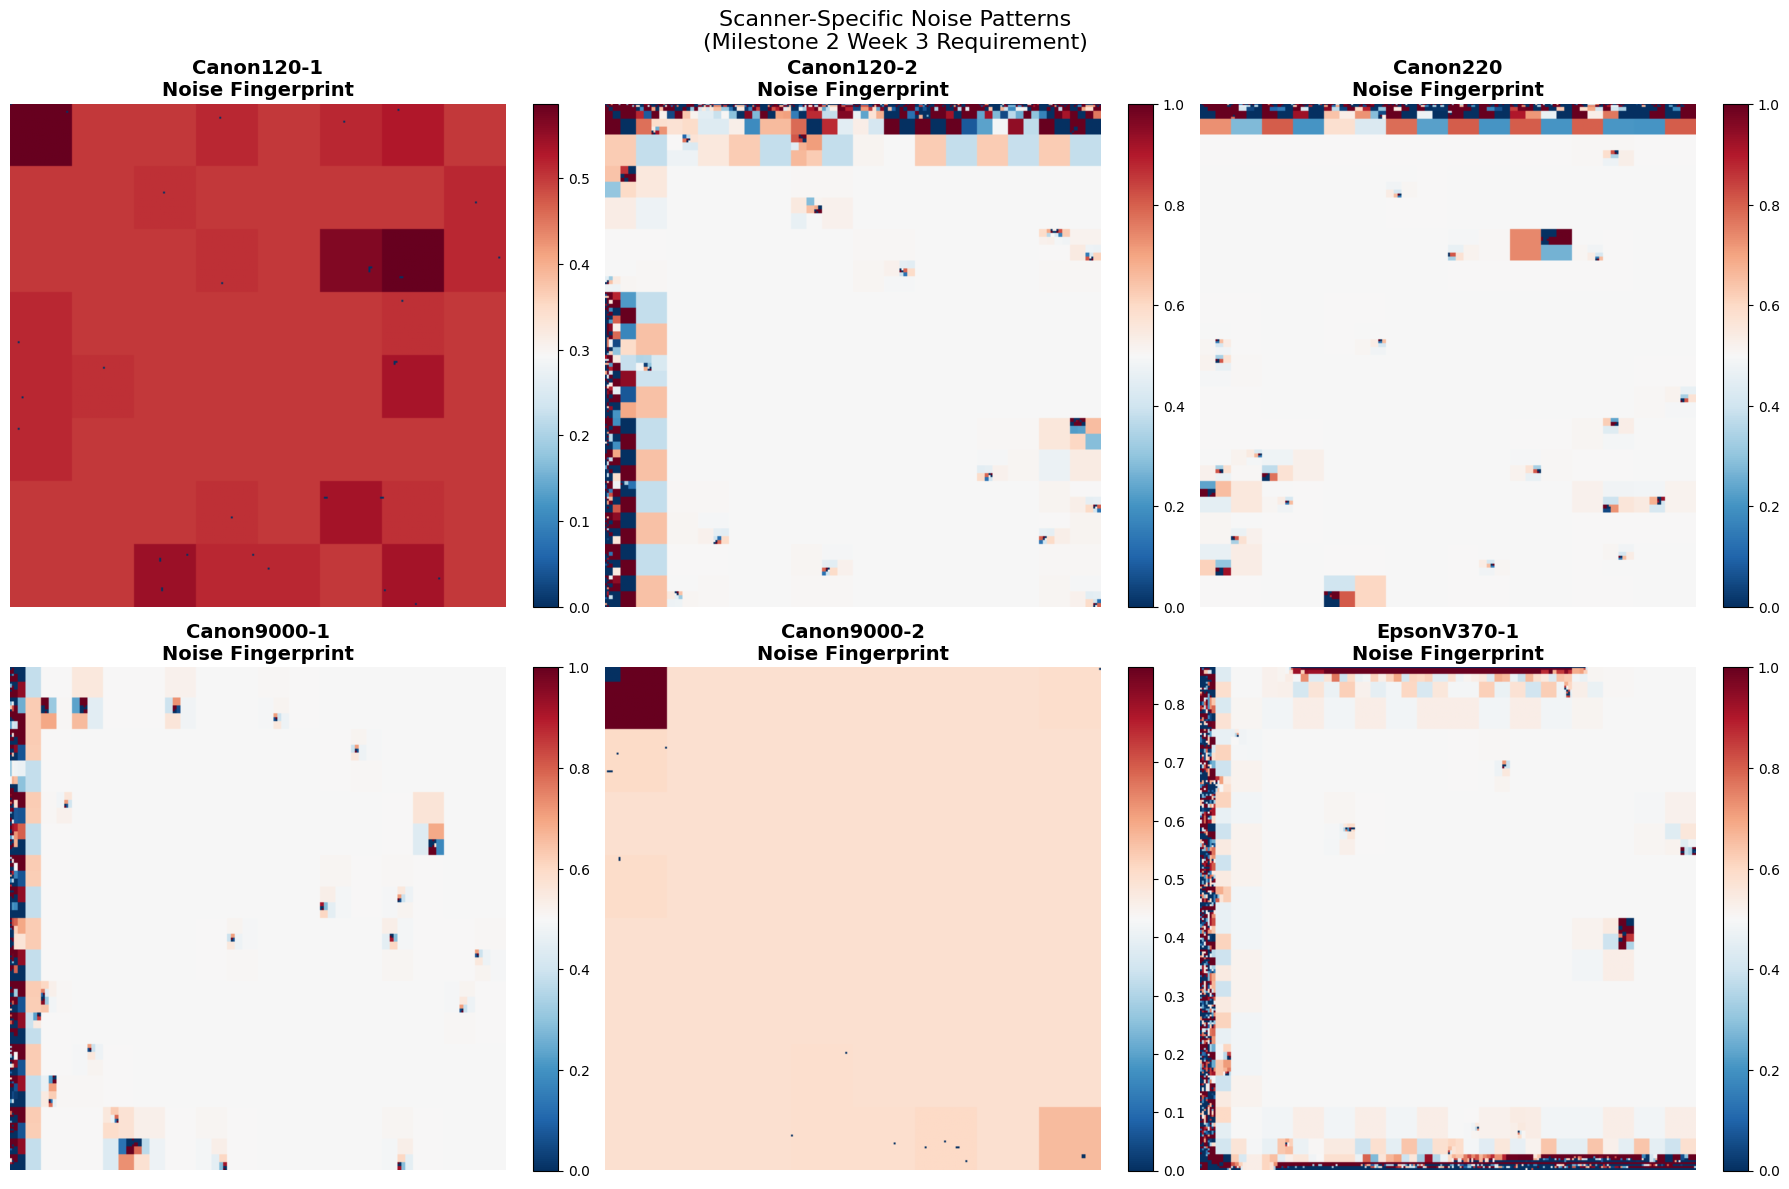

✅ Scanner noise visualization complete - Milestone 2 Week 3 ✅


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pickle  # FIX: Add missing import
import os

def visualize_scanner_differences():
    """Visualize differences between scanner outputs (noise maps) - REQUIRED by Week 3"""

    with open("/content/drive/MyDrive/Objective1/scanner_fingerprints.pkl", "rb") as f:
        scanner_fps = pickle.load(f)

    # Create noise pattern visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    scanners = list(scanner_fps.keys())[:6]

    for i, scanner in enumerate(scanners):
        fp = scanner_fps[scanner]

        # Enhance contrast for visualization
        fp_enhanced = (fp - fp.mean()) / (fp.std() + 1e-8) * 0.5 + 0.5
        fp_clipped = np.clip(fp_enhanced, 0, 1)

        im = axes[i].imshow(fp_clipped, cmap='RdBu_r', aspect='auto')
        axes[i].set_title(f'{scanner}\nNoise Fingerprint', fontsize=14, fontweight='bold')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046)

    plt.suptitle('Scanner-Specific Noise Patterns\n(Milestone 2 Week 3 Requirement)', fontsize=16)
    plt.tight_layout()

    # Save plot
    os.makedirs('/content/drive/MyDrive/Objective1/metrics', exist_ok=True)
    plt.savefig('/content/drive/MyDrive/Objective1/metrics/scanner_noise_maps.png',
                dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Scanner noise visualization complete - Milestone 2 Week 3 ✅")

# Run visualization
visualize_scanner_differences()


Prints a hierarchical tree of Objective1 with indentation for subfolders.

Lists subfolders at each level and recurses into them.

Shows only a small sample of files per folder (default 3) for quick inspection.

Indicates when more files exist in a folder beyond the shown sample.

In [ ]:
import os

base_dir = "/content/drive/MyDrive/Objective1"

def list_folders(path, indent=0, file_limit=3):
    # Print current folder name
    print(" " * indent + f"📂 {os.path.basename(path)}/")

    try:
        items = os.listdir(path)
    except PermissionError:
        return

    subfolders = [f for f in items if os.path.isdir(os.path.join(path, f))]
    files = [f for f in items if os.path.isfile(os.path.join(path, f))]

    # Print subfolders
    if subfolders:
        print(" " * (indent + 2) + "Subfolders:", subfolders)
        for sf in subfolders:
            list_folders(os.path.join(path, sf), indent + 4, file_limit)

    # Print only sample files
    if files:
        sample_files = files[:file_limit]
        print(" " * (indent + 2) + "Files (sample):", sample_files)
        if len(files) > file_limit:
            print(" " * (indent + 2) + f"... (+{len(files) - file_limit} more)")

# Run it
list_folders(base_dir)


📂 Objective1/
  Subfolders: ['Flatfield', 'Originals', 'Official', 'Wikipedia', 'Tampered images', 'metrics']
    📂 Flatfield/
      Subfolders: ['Canon120-1', 'EpsonV39-1', 'Canon120-2', 'Canon220', 'HP', 'EpsonV370-2', 'EpsonV39-2', 'Canon9000-1', 'EpsonV550', 'EpsonV370-1', 'Canon9000-2']
        📂 Canon120-1/
          Files (sample): ['300.tif', '150.tif']
        📂 EpsonV39-1/
          Files (sample): ['300.tif', '150.tif', '._150.tif']
        📂 Canon120-2/
          Files (sample): ['300.tif', '150.tif']
        📂 Canon220/
          Files (sample): ['300.tif', '150.tif']
        📂 HP/
          Files (sample): ['300.tif', '150.tif']
        📂 EpsonV370-2/
          Files (sample): ['300.tif', '150.tif']
        📂 EpsonV39-2/
          Files (sample): ['300.tif', '150.tif']
        📂 Canon9000-1/
          Files (sample): ['300.tif', '150.tif']
        📂 EpsonV550/
          Files (sample): ['300.tif', '150.tif']
        📂 EpsonV370-1/
          Files (sample): ['300.tif', '15

Loads scanner fingerprints and a fixed scanner key order to ensure consistent feature vector layout.

Defines corr2d to compute zero-mean normalized cross-correlation (ZNCC) between an image residual and each fingerprint.

Loads precomputed residuals for Official and Wikipedia and iterates by scanner and DPI.

For every residual image, builds a feature vector as correlations to all fingerprints in fp_keys order and records the corresponding scanner label.

Saves features and labels to features.pkl and prints the resulting matrix shape.

In [ ]:
# ==============================
# STEP 4 : Feature Extraction using existing residuals + stable order
# ==============================
import pickle, numpy as np
from tqdm import tqdm

# Paths
RES_PATH   = "/content/drive/MyDrive/Objective1/official_wiki_residuals.pkl"
FP_PATH    = "/content/drive/MyDrive/Objective1/scanner_fingerprints.pkl"
ORDER_NPY  = "/content/drive/MyDrive/Objective1/fp_keys.npy"
OUT_PATH   = "/content/drive/MyDrive/Objective1/features.pkl"d

# Load fingerprints and fixed order
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()
print("✅ Loaded fingerprints and key order. Keys:", fp_keys)

# Helper: normalized cross-correlation (zero-mean cosine similarity)
def corr2d(a, b):
    a = a.astype(np.float32).ravel()
    b = b.astype(np.float32).ravel()
    a -= a.mean()
    b -= b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float((a @ b) / denom) if denom != 0 else 0.0
# ZNCC equals the dot product of zero-mean, unit-norm vectors, i.e., cosine similarity in L2 space. [web:188][web:189][web:169]

# Load residuals (already precomputed; do not preprocess again)
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
print("✅ Loaded residuals for datasets:", list(residuals_dict.keys()))

# Build features in the exact fp_keys order
features, labels = [], []
for dataset_name in ["Official", "Wikipedia"]:
    print(f"🔄 Computing features for {dataset_name} ...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                vec = [corr2d(res, scanner_fps[k]) for k in fp_keys]
                features.append(vec)
                labels.append(scanner)

# Save features + labels
with open(OUT_PATH, "wb") as f:
    pickle.dump({"features": features, "labels": labels}, f)
print(f"✅ Saved features + labels to {OUT_PATH}")
print("Shape:", (len(features), len(features[0]) if features else 0))


✅ Loaded fingerprints and key order. Keys: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']
✅ Loaded residuals for datasets: ['Official', 'Wikipedia']
🔄 Computing features for Official ...


100%|██████████| 11/11 [00:03<00:00,  2.86it/s]


🔄 Computing features for Wikipedia ...


100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


✅ Saved features + labels to /content/drive/MyDrive/Objective1/features.pkl
Shape: (4568, 11)


In [ ]:
# ==============================
# STEP 4B: Enhanced Feature Extraction (FFT + LBP + Texture)
# ==============================
import pickle, numpy as np
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from scipy import ndimage
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

# Load existing residuals
RES_PATH = "/content/drive/MyDrive/Objective1/official_wiki_residuals.pkl"
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)

def extract_enhanced_features(residual):
    """Extract comprehensive features: PRNU correlation + FFT + LBP + Texture"""

    # 1. FFT Features (frequency domain)
    fft_img = np.abs(fft2(residual))
    fft_img = fftshift(fft_img)

    # Extract frequency bands
    h, w = fft_img.shape
    center_h, center_w = h//2, w//2

    # Low, mid, high frequency energy
    low_freq = np.mean(fft_img[center_h-20:center_h+20, center_w-20:center_w+20])
    mid_freq = np.mean(fft_img[center_h-60:center_h+60, center_w-60:center_w+60]) - low_freq
    high_freq = np.mean(fft_img) - low_freq - mid_freq

    # 2. LBP Texture Features
    lbp = local_binary_pattern(residual, P=24, R=3, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 25), density=True)

    # 3. Statistical Texture Features
    grad_x = ndimage.sobel(residual, axis=1)
    grad_y = ndimage.sobel(residual, axis=0)
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)

    texture_features = [
        np.std(residual),           # Standard deviation
        np.mean(np.abs(residual)),  # Mean absolute value
        np.std(gradient_mag),       # Gradient variation
        np.mean(gradient_mag),      # Edge strength
    ]

    return [low_freq, mid_freq, high_freq] + lbp_hist.tolist() + texture_features

# Extract enhanced features for all images
print("🔄 Extracting enhanced features (FFT + LBP + Texture)...")
enhanced_features, enhanced_labels = [], []

for dataset_name in ["Official", "Wikipedia"]:
    print(f"Processing {dataset_name}...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                feat = extract_enhanced_features(res)
                enhanced_features.append(feat)
                enhanced_labels.append(scanner)

# Save enhanced features
ENHANCED_OUT = "/content/drive/MyDrive/Objective1/enhanced_features.pkl"
with open(ENHANCED_OUT, "wb") as f:
    pickle.dump({"features": enhanced_features, "labels": enhanced_labels}, f)

print(f"✅ Enhanced features shape: {len(enhanced_features)} x {len(enhanced_features[0])}")
print(f"✅ Saved to {ENHANCED_OUT}")


🔄 Extracting enhanced features (FFT + LBP + Texture)...
Processing Official...


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 11/11 [01:50<00:00, 10.04s/it]


Processing Wikipedia...


100%|██████████| 11/11 [01:57<00:00, 10.70s/it]

✅ Enhanced features shape: 4568 x 33
✅ Saved to /content/drive/MyDrive/Objective1/enhanced_features.pkl


🔄 Creating PCA visualization...


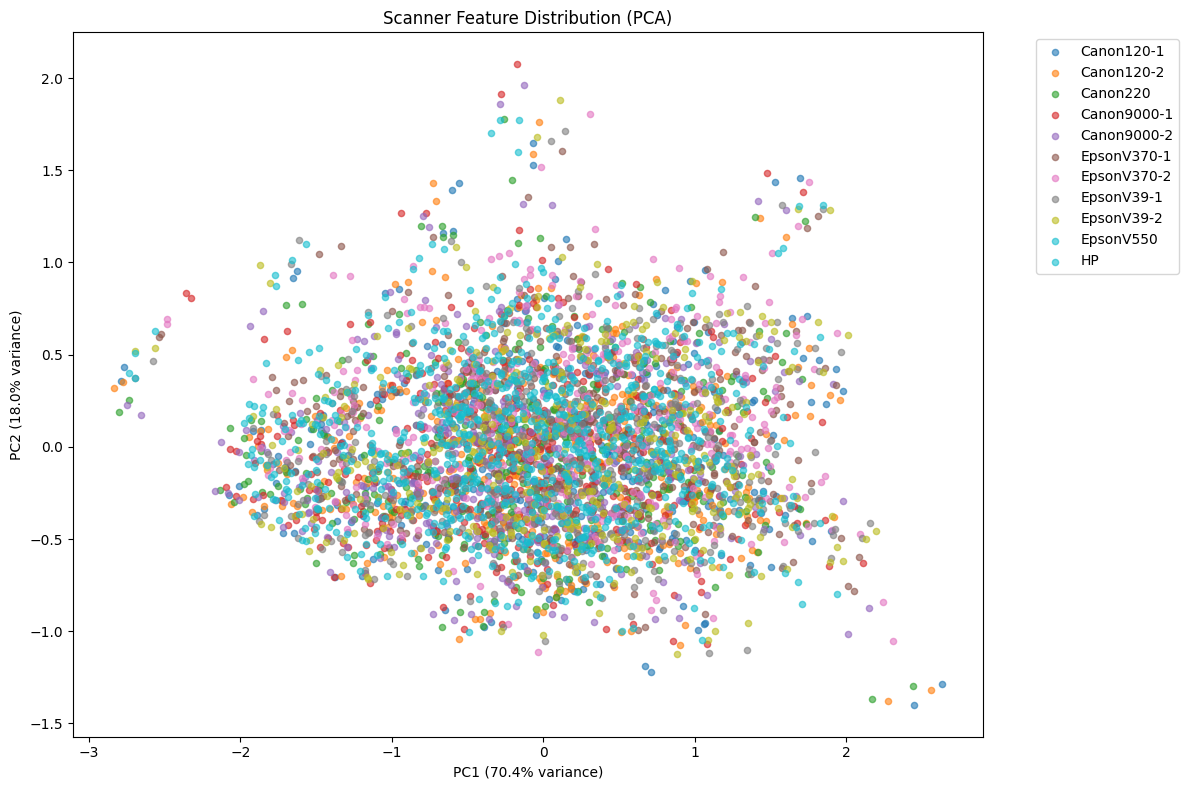

🔄 Creating t-SNE visualization...


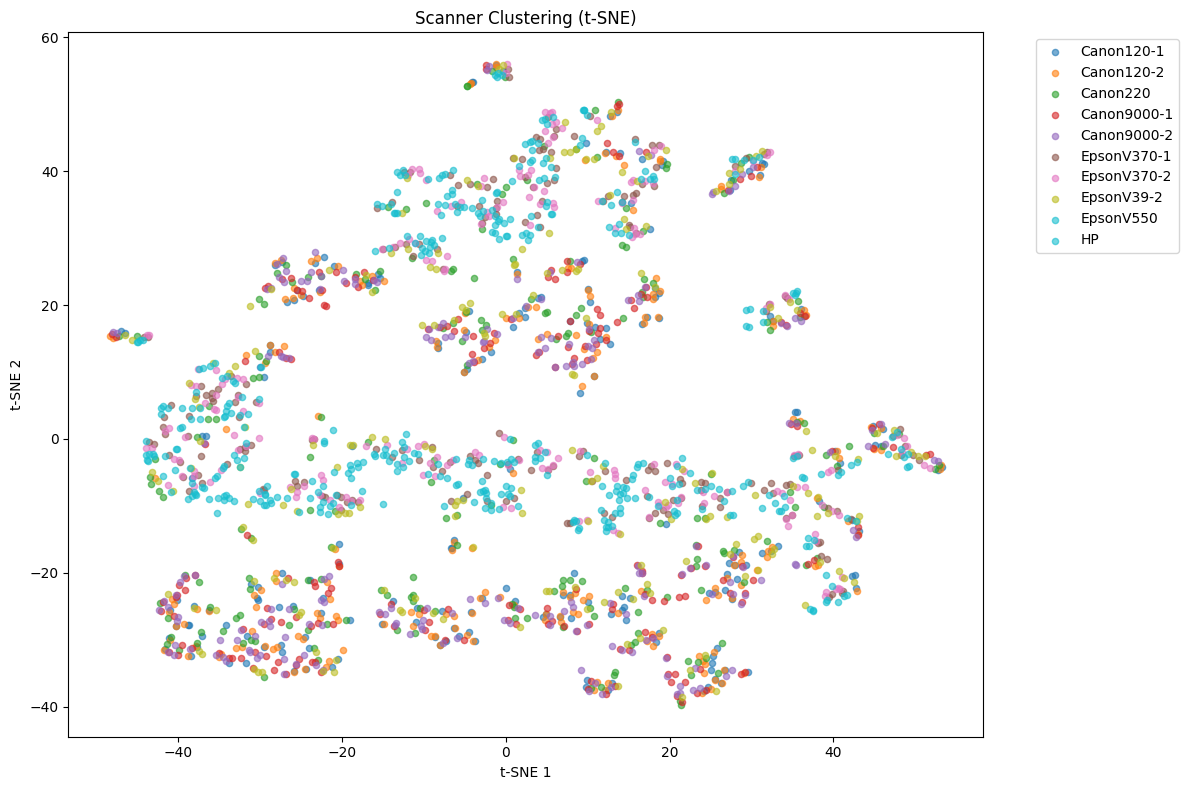

🔄 Computing feature correlations...


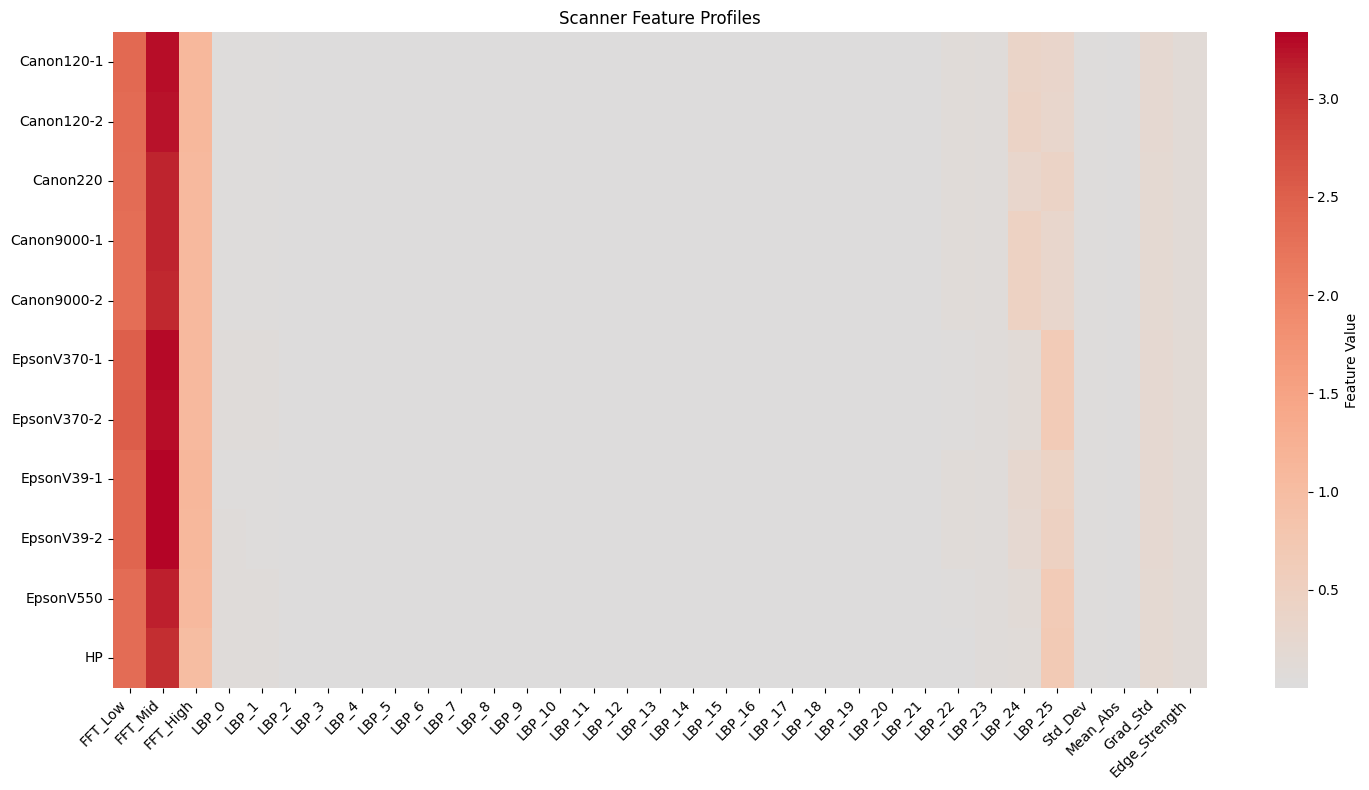

✅ Visualizations saved to /content/drive/MyDrive/Objective1/


In [ ]:
# ==============================
# STEP 4C: Feature Visualization & Scanner Differences
# ==============================
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load enhanced features
with open("/content/drive/MyDrive/Objective1/enhanced_features.pkl", "rb") as f:
    data = pickle.load(f)

X = np.array(data["features"])
y = np.array(data["labels"])

# 1. PCA Visualization
print("🔄 Creating PCA visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 8))
scanners = np.unique(y)
colors = plt.cm.tab10(np.linspace(0, 1, len(scanners)))

for i, scanner in enumerate(scanners):
    mask = y == scanner
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                c=[colors[i]], label=scanner, alpha=0.6, s=20)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Scanner Feature Distribution (PCA)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Objective1/pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. t-SNE Visualization
print("🔄 Creating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X[:2000])  # Subset for speed
y_subset = y[:2000]

plt.figure(figsize=(12, 8))
for i, scanner in enumerate(scanners):
    mask = y_subset == scanner
    if np.sum(mask) > 0:
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                    c=[colors[i]], label=scanner, alpha=0.6, s=20)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Scanner Clustering (t-SNE)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Objective1/tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Feature Importance Heatmap
print("🔄 Computing feature correlations...")
feature_names = (['FFT_Low', 'FFT_Mid', 'FFT_High'] +
                [f'LBP_{i}' for i in range(26)] +
                ['Std_Dev', 'Mean_Abs', 'Grad_Std', 'Edge_Strength'])

# Compute mean features per scanner
scanner_profiles = {}
for scanner in scanners:
    mask = y == scanner
    scanner_profiles[scanner] = np.mean(X[mask], axis=0)

# Create heatmap data
heatmap_data = np.array([scanner_profiles[s] for s in scanners])

plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data,
            xticklabels=feature_names,
            yticklabels=scanners,
            cmap='coolwarm', center=0,
            cbar_kws={'label': 'Feature Value'})
plt.title('Scanner Feature Profiles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Objective1/feature_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved to /content/drive/MyDrive/Objective1/")


Milestone 3 — Deep model + explainability

In [ ]:
# ==============================
# 5C: Hybrid CNN (Residual Image + Handcrafted Features)
# This block replaces your Step 5 CNN and Step 7 inference
# Place it AFTER Step 4B (Enhanced Feature Extraction)
# ==============================

# ---- Imports & Paths ----
import os, pickle, pywt, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from skimage.feature import local_binary_pattern as sk_lbp

RES_PATH  = "/content/drive/MyDrive/Objective1/official_wiki_residuals.pkl"
FP_PATH   = "/content/drive/MyDrive/Objective1/scanner_fingerprints.pkl"
ORDER_NPY = "/content/drive/MyDrive/Objective1/fp_keys.npy"
ART_DIR   = "/content/drive/MyDrive/Objective1"
os.makedirs(ART_DIR, exist_ok=True)

# ---- Reproducibility ----
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ---- Load residuals + fingerprints in stable order ----
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()

# ---- Utilities (NumPy 2.0-safe + residual features) ----
def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    # Float-safe: normalize and cast to uint8, use np.ptp for NumPy 2.0
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2  # uniform -> P+2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()  # length 10 for P=8

# ---- Build aligned dataset: (residual image, 27-D features, label) ----
X_img, X_feat, y = [], [], []
for dataset_name in ["Official", "Wikipedia"]:
    for scanner, dpi_dict in residuals_dict[dataset_name].items():
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                # Image branch
                X_img.append(np.expand_dims(res, axis=-1))  # (256,256,1)
                # Feature branch: 11 PRNU corr + 6 FFT energy + 10 LBP
                v_corr = [corr2d(res, scanner_fps[k]) for k in fp_keys]   # 11
                v_fft  = fft_radial_energy(res, K=6)                      # 6
                v_lbp  = lbp_hist_safe(res, P=8, R=1.0)                   # 10
                X_feat.append(v_corr + v_fft + v_lbp)                     # 27 total
                y.append(scanner)

X_img  = np.array(X_img, dtype=np.float32)    # (N,256,256,1)
X_feat = np.array(X_feat, dtype=np.float32)   # (N,27)
y       = np.array(y)

# ---- Encode labels and split ----
le = LabelEncoder()
y_int = le.fit_transform(y)
num_classes = len(le.classes_)
y_cat = to_categorical(y_int, num_classes)

X_img_tr, X_img_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(
    X_img, X_feat, y_cat, test_size=0.2, random_state=SEED, stratify=y_int
)

# Feature scaling on train only
scaler = StandardScaler()
X_feat_tr = scaler.fit_transform(X_feat_tr)
X_feat_te = scaler.transform(X_feat_te)

# Persist artifacts
with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print("Hybrid train:", X_img_tr.shape, X_feat_tr.shape, y_tr.shape)
print("Hybrid test :", X_img_te.shape, X_feat_te.shape, y_te.shape)

# ---- Hybrid model: fixed high-pass residual frontend + feature MLP ----
img_in  = keras.Input(shape=(256,256,1), name="residual")
feat_in = keras.Input(shape=(27,),      name="handcrafted")

# Fixed high-pass kernel (content suppression)
hp_kernel = np.array([[-1,-1,-1],
                      [-1, 8,-1],
                      [-1,-1,-1]], dtype=np.float32).reshape((3,3,1,1))

hp = layers.Conv2D(1, (3,3), padding="same", use_bias=False, trainable=False, name="hp_filter")(img_in)

x = layers.Conv2D(32, (3,3), padding="same", activation=None)(hp)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, (3,3), padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, (3,3), padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.30)(x)

x = layers.Conv2D(256, (3,3), padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.GlobalAveragePooling2D()(x)  # CNN embedding

# Feature branch
f = layers.Dense(64, activation=None)(feat_in)
f = layers.BatchNormalization()(f); f = layers.ReLU()(f)
f = layers.Dropout(0.20)(f)

# Fuse and classify
z = layers.Concatenate()([x, f])
z = layers.Dense(256, activation="relu")(z)
z = layers.Dropout(0.40)(z)
out = layers.Dense(num_classes, activation="softmax")(z)

model = keras.Model(inputs=[img_in, feat_in], outputs=out, name="scanner_hybrid")
model.get_layer("hp_filter").set_weights([hp_kernel])

opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# ---- tf.data pipelines ----
BATCH = 32
train_ds = tf.data.Dataset.from_tensor_slices(((X_img_tr, X_feat_tr), y_tr))\
    .shuffle(len(y_tr), reshuffle_each_iteration=True)\
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices(((X_img_te, X_feat_te), y_te))\
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)

# ---- Callbacks (.keras modern format) ----
ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, monitor="val_accuracy"),
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy"),
]

# ---- Train ----
EPOCHS = 50
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks, verbose=1)

# ---- Save final model + history ----
final_path = os.path.join(ART_DIR, "scanner_hybrid_final.keras")
model.save(final_path)
with open(os.path.join(ART_DIR, "hybrid_training_history.pkl"), "wb") as f:
    pickle.dump(history.history, f)
print("✅ Hybrid CNN training complete:", ckpt_path)

# ==============================
# 5C.3 — Hybrid Inference (matches Step 2B pywt/Haar denoiser)
# ==============================

# Reload for inference (optional)
hyb_model = tf.keras.models.load_model(ckpt_path)
with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "rb") as f:
    le_inf = pickle.load(f)
with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "rb") as f:
    scaler_inf = pickle.load(f)
with open(FP_PATH, "rb") as f:
    scanner_fps_inf = pickle.load(f)
fp_keys_inf = np.load(ORDER_NPY, allow_pickle=True).tolist()

IMG_SIZE = (256,256)

def preprocess_residual_pywt(path):
    import cv2
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def make_feats_from_res(res):
    v_corr = [corr2d(res, scanner_fps_inf[k]) for k in fp_keys_inf]  # 11
    v_fft  = fft_radial_energy(res, K=6)                              # 6
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)                           # 10
    v = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    v = scaler_inf.transform(v)
    return v

def predict_scanner_hybrid(image_path):
    res   = preprocess_residual_pywt(image_path)
    x_img = np.expand_dims(res, axis=(0,-1))      # (1,256,256,1)
    x_ft  = make_feats_from_res(res)              # (1,27)
    prob  = hyb_model.predict([x_img, x_ft], verbose=0)
    idx   = int(np.argmax(prob))
    label = le_inf.classes_[idx]
    conf  = float(prob[idx]*100.0)
    return label, conf

# ---- Example usage ----
# test_paths = [
#   "/content/drive/MyDrive/Objective1/Official/Canon220/150/s3_25.tif",
#   "/content/drive/MyDrive/Objective1/Official/HP/150/s11_22.tif",
#   "/content/drive/MyDrive/Objective1/Wikipedia/Canon120-1/300/s1_5.tif",
# ]
# for p in test_paths:
#     lab, conf = predict_scanner_hybrid(p)
#     print(p, "->", lab, f"| {conf:.2f}%")


Hybrid train: (3654, 256, 256, 1) (3654, 27) (3654, 11)
Hybrid test : (914, 256, 256, 1) (914, 27) (914, 11)


Model: "scanner_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ residual            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hp_filter (Conv2D)  │ (None, 256, 256,  │          9 │ residual[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ hp_filter[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 670,580 (2.56 MB)

 Trainable params: 669,483 (2.55 MB)

 Non-trainable params: 1,097 (4.29 KB)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 76s 386ms/step - accuracy: 0.2803 - loss: 2.0318 - val_accuracy: 0.2319 - val_loss: 3.6009 - learning_rate: 0.0010
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - accuracy: 0.4667 - loss: 1.3948 - val_accuracy: 0.5383 - val_loss: 1.2655 - learning_rate: 0.0010
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 23s 197ms/step - accuracy: 0.5220 - loss: 1.2675 - val_accuracy: 0.5875 - val_loss: 1.1665 - learning_rate: 0.0010
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.5282 - loss: 1.2226 - val_accuracy: 0.5536 - val_loss: 1.2027 - learning_rate: 0.0010
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.5365 - loss: 1.1573 - val_accuracy: 0.5066 - val_loss: 1.3666 - learning_rate: 0.0010
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.5657 - loss: 1.0701 - val_accuracy: 0.5098 - val_loss: 1.2935 - learning_rate: 0.0010
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - accuracy: 0.5

In [ ]:
# Auto-sample per scanner and run batch inference with confidences

import os, csv, numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

OUT_CSV = "/content/drive/MyDrive/Objective1/metrics/inference_hybrid.csv"
ROOT_OFF = "/content/drive/MyDrive/Objective1/Official"
ROOT_WIK = "/content/drive/MyDrive/Objective1/Wikipedia"

def parse_gt_from_path(p):
    parts = p.split("/")
    if "Official" in parts:
        i = parts.index("Official")
    elif "Wikipedia" in parts:
        i = parts.index("Wikipedia")
    else:
        return None
    return parts[i+1] if i+1 < len(parts) else None

def collect_samples(root_dir, per_scanner=10):
    paths = []
    for scanner in sorted(os.listdir(root_dir)):
        sp = os.path.join(root_dir, scanner)
        if not os.path.isdir(sp): continue
        picked = 0
        # iterate 150 and 300 folders if present
        for dpi in sorted(os.listdir(sp)):
            dp = os.path.join(sp, dpi)
            if not os.path.isdir(dp): continue
            for f in sorted(os.listdir(dp)):
                if f.lower().endswith((".tif",".tiff",".png",".jpg",".jpeg")):
                    paths.append(os.path.join(dp, f))
                    picked += 1
                    if picked >= per_scanner: break
            if picked >= per_scanner: break
    return paths

def topk_indices_1d(p, k=3):
    p = np.asarray(p).ravel()
    k = min(k, p.size)
    idx = np.argpartition(p, -k)[-k:]
    idx = idx[np.argsort(p[idx])[::-1]]
    return idx

# Collect 10 per scanner from both sets (adjust per_scanner if needed)
test_paths = collect_samples(ROOT_OFF, per_scanner=10) + collect_samples(ROOT_WIK, per_scanner=10)
print("Total test files:", len(test_paths))

rows = [["path","pred_label","conf_pct","top3_labels","top3_conf","gt_label","correct"]]
y_true, y_pred = [], []

for p in test_paths:
    try:
        res   = preprocess_residual_pywt(p)
        x_img = np.expand_dims(res, axis=(0,-1))
        x_ft  = make_feats_from_res(res)
        prob  = hyb_model.predict([x_img, x_ft], verbose=0)
        prob  = np.asarray(prob).ravel()     # 1D softmax vector

        top1  = int(np.argmax(prob))
        label = le_inf.classes_[top1]
        conf  = float(prob[top1] * 100.0)

        top3_idx = topk_indices_1d(prob, k=3)
        top3_labels = [le_inf.classes_[i] for i in top3_idx]
        top3_conf   = [float(prob[i]*100.0) for i in top3_idx]

        gt = parse_gt_from_path(p)
        correct = (gt == label) if gt is not None else ""
        rows.append([p, label, f"{conf:.2f}",
                    ";".join(top3_labels),
                    ";".join(f"{c:.2f}" for c in top3_conf),
                    gt if gt else "", correct])

        if gt is not None:
            y_true.append(gt); y_pred.append(label)
    except Exception as e:
        rows.append([p, "ERROR", "", "", "", "", f"err={e}"])

# Write CSV
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
with open(OUT_CSV, "w", newline="") as fh:
    csv.writer(fh).writerows(rows)
print("Wrote:", OUT_CSV)

# Metrics: present labels only (no undefined warnings)
present = unique_labels(y_true, y_pred)
print(classification_report(y_true, y_pred, labels=present))

# Also full report on all 11 classes with zero_division=0
print(classification_report(y_true, y_pred, labels=list(le_inf.classes_), zero_division=0))

# Confusion matrix on present labels
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred, labels=present))


Total test files: 220
Wrote: /content/drive/MyDrive/Objective1/metrics/inference_hybrid.csv
              precision    recall  f1-score   support

  Canon120-1       0.76      0.95      0.84        20
  Canon120-2       0.88      0.70      0.78        20
    Canon220       1.00      0.95      0.97        20
 Canon9000-1       0.94      0.85      0.89        20
 Canon9000-2       0.86      0.95      0.90        20
 EpsonV370-1       1.00      0.85      0.92        20
 EpsonV370-2       0.87      1.00      0.93        20
  EpsonV39-1       1.00      1.00      1.00        20
  EpsonV39-2       1.00      1.00      1.00        20
   EpsonV550       1.00      1.00      1.00        20
          HP       1.00      1.00      1.00        20

    accuracy                           0.93       220
   macro avg       0.94      0.93      0.93       220
weighted avg       0.94      0.93      0.93       220

              precision    recall  f1-score   support

  Canon120-1       0.76      0.95      0

In [ ]:
# Simple per-line print: path -> predicted_label | confidence%
import numpy as np

print("✅ Loaded fingerprints, fixed key order, and model.")

# 10 paths (5 Official + 5 Wikipedia) — edit as desired
test_paths = [
  # Official (5)
  "/content/drive/MyDrive/Objective1/Official/Canon120-1/150/s1_60.tif",
  "/content/drive/MyDrive/Objective1/Official/Canon120-2/300/s2_40.tif",
  "/content/drive/MyDrive/Objective1/Official/Canon220/150/s3_25.tif",
  "/content/drive/MyDrive/Objective1/Official/Canon9000-1/300/s4_75.tif",
  "/content/drive/MyDrive/Objective1/Official/Canon9000-2/150/s5_10.tif",
  # Wikipedia (5)
  "/content/drive/MyDrive/Objective1/Wikipedia/Canon120-1/300/s1_5.tif",
  "/content/drive/MyDrive/Objective1/Wikipedia/Canon220/150/s3_1.tif",
  "/content/drive/MyDrive/Objective1/Wikipedia/Canon9000-1/300/s4_5.tif",
  "/content/drive/MyDrive/Objective1/Wikipedia/EpsonV39-2/150/s9_66.tif",
  "/content/drive/MyDrive/Objective1/Wikipedia/HP/150/s11_1.tif",
]

for p in test_paths:
    # Residual + features (match training)
    res   = preprocess_residual_pywt(p)                  # (256,256)
    x_img = np.expand_dims(res, axis=(0,-1))             # (1,256,256,1)
    x_ft  = make_feats_from_res(res)                     # (1,27) scaled

    # Predict -> flatten to 1D softmax vector
    prob  = hyb_model.predict([x_img, x_ft], verbose=0)
    prob  = np.asarray(prob).ravel()                     # (C,) fixes TypeError

    idx   = int(np.argmax(prob))
    label = le_inf.classes_[idx]
    conf  = float(prob[idx] * 100.0)
    print(f"{p} -> {label} | {conf:.2f}%")


✅ Loaded fingerprints, fixed key order, and model.
/content/drive/MyDrive/Objective1/Official/Canon120-1/150/s1_60.tif -> Canon120-1 | 94.72%
/content/drive/MyDrive/Objective1/Official/Canon120-2/300/s2_40.tif -> Canon120-2 | 87.11%
/content/drive/MyDrive/Objective1/Official/Canon220/150/s3_25.tif -> Canon220 | 93.96%
/content/drive/MyDrive/Objective1/Official/Canon9000-1/300/s4_75.tif -> Canon9000-1 | 86.03%
/content/drive/MyDrive/Objective1/Official/Canon9000-2/150/s5_10.tif -> Canon9000-2 | 94.59%
/content/drive/MyDrive/Objective1/Wikipedia/Canon120-1/300/s1_5.tif -> Canon120-2 | 64.08%
/content/drive/MyDrive/Objective1/Wikipedia/Canon220/150/s3_1.tif -> Canon220 | 99.87%
/content/drive/MyDrive/Objective1/Wikipedia/Canon9000-1/300/s4_5.tif -> Canon9000-1 | 99.97%
/content/drive/MyDrive/Objective1/Wikipedia/EpsonV39-2/150/s9_66.tif -> EpsonV39-2 | 99.79%
/content/drive/MyDrive/Objective1/Wikipedia/HP/150/s11_1.tif -> HP | 100.00%


In [ ]:
import pickle, numpy as np, tensorflow as tf

# Example Drive paths — adjust only if files are in a different Drive folder
model_path = "/content/drive/MyDrive/Objective1/scanner_hybrid.keras"
le_path    = "/content/drive/MyDrive/Objective1/hybrid_label_encoder.pkl"
scaler_path= "/content/drive/MyDrive/Objective1/hybrid_feat_scaler.pkl"
fps_path   = "/content/drive/MyDrive/Objective1/scanner_fingerprints.pkl"
keys_path  = "/content/drive/MyDrive/Objective1/fp_keys.npy"

# Load from Drive into memory
hyb_model = tf.keras.models.load_model(model_path)
with open(le_path, "rb") as f:     le_inf     = pickle.load(f)
with open(scaler_path, "rb") as f: scaler_inf = pickle.load(f)
with open(fps_path, "rb") as f:    scanner_fps_inf = pickle.load(f)
fp_keys_inf = np.load(keys_path, allow_pickle=True).tolist()

# Save to /content for download
tf.keras.models.save_model(hyb_model, "/content/scanner_hybrid.keras")
with open("/content/hybrid_label_encoder.pkl", "wb") as f: pickle.dump(le_inf, f)
with open("/content/hybrid_feat_scaler.pkl", "wb") as f: pickle.dump(scaler_inf, f)
with open("/content/scanner_fingerprints.pkl", "wb") as f: pickle.dump(scanner_fps_inf, f)
np.save("/content/fp_keys.npy", np.array(fp_keys_inf, dtype=object))


Imported libraries for image processing, ML, and PDF handling.

Set random seed for reproducibility.

Prepared tools for feature extraction (Wavelets, LBP) and scaling.

Set up data splitting, SVM model, and evaluation metrics.

In [ ]:
!pip -q install pymupdf

import os, glob, csv, pickle, random
from pathlib import Path
import numpy as np
import cv2, pywt
from PIL import Image
from tqdm import tqdm
import fitz  # PyMuPDF

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from skimage.feature import local_binary_pattern as sk_lbp

SEED = 42
random.seed(SEED); np.random.seed(SEED)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 94.4 MB/s eta 0:00:00


Defined root directory for the project.

Set paths for original PDFs and their converted TIFF outputs.

Set paths for tampered TIFF images (Copy-move, Retouching, Splicing).

Created folders for artifacts and manifest files if they don’t exist.

In [ ]:
ROOT = "/content/drive/MyDrive/Objective1"

# Originals PDFs to convert → TIFF
ORIG_PDF_OFF = f"{ROOT}/Originals/official"
ORIG_PDF_WIK = f"{ROOT}/Originals/wikipedia"
CONV_OUT     = f"{ROOT}/Originals_tif"           # output for converted TIFFs
os.makedirs(CONV_OUT, exist_ok=True)

# Tampered images TIFFs
TAMP_ROOT     = f"{ROOT}/Tampered images"
TAMP_ORIG_TIF = f"{TAMP_ROOT}/Original"                          # clean (0)
TAMP_COPY_TIF = f"{TAMP_ROOT}/Tampered/Copy-move"                # tampered (1)
TAMP_RETO_TIF = f"{TAMP_ROOT}/Tampered/Retouching"               # tampered (1)
TAMP_SPLI_TIF = f"{TAMP_ROOT}/Tampered/Splicing"                 # tampered (1)

# Artifacts / manifests
ART_DIR      = f"{ROOT}/artifacts_tamper"
MANIFEST_CSV = f"{ROOT}/manifests/tamper_manifest.csv"
os.makedirs(ART_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MANIFEST_CSV), exist_ok=True)


Wrote a function to convert each PDF page into TIFF images at 300 DPI.

Ensured output images are in RGB mode and saved with compression.

Collected all PDFs from official and wikipedia folders for batch processing.

Converted them in bulk, showing progress and handling errors gracefully.

In [ ]:
def pdf_to_tiffs(pdf_path, out_dir, dpi=300):
    os.makedirs(out_dir, exist_ok=True)
    doc = fitz.open(pdf_path)
    for i, page in enumerate(doc):
        pix = page.get_pixmap(dpi=dpi)  # documented DPI rendering
        mode = "RGB" if pix.alpha == 0 else "RGBA"
        img = Image.frombytes(mode, [pix.width, pix.height], pix.samples)
        if img.mode != "RGB":
            img = img.convert("RGB")
        stem = Path(pdf_path).stem
        outp = f"{out_dir}/{stem}_p{i+1}.tif"
        img.save(outp, format="TIFF", dpi=(dpi, dpi), compression="tiff_deflate")
    doc.close()

def batch_convert_originals():
    tasks = []
    for sub in ["official", "wikipedia"]:
        src_root = f"{ROOT}/Originals/{sub}"
        dst_root = f"{CONV_OUT}/{sub}"
        os.makedirs(dst_root, exist_ok=True)
        for pdf in glob.glob(f"{src_root}/**/*.pdf", recursive=True):
            parent = Path(pdf).parent.name
            out_dir = f"{dst_root}/{parent}"
            tasks.append((pdf, out_dir))
    for pdf, outd in tqdm(tasks, desc="PDF→TIFF 300dpi"):
        try:
            pdf_to_tiffs(pdf, outd, dpi=300)
        except Exception as e:
            print("Failed:", pdf, "->", e)

batch_convert_originals()


PDF→TIFF 300dpi: 100%|██████████| 208/208 [02:45<00:00,  1.25it/s]


Set root path for the project.

Defined paths for converted TIFFs of official and wikipedia originals.

Defined paths for tampered image categories (Original, Copy-move, Retouching, Splicing).

In [ ]:
ROOT = "/content/drive/MyDrive/Objective1"
ORIG_TIF_OFF = f"{ROOT}/Originals_tif/official"
ORIG_TIF_WIK = f"{ROOT}/Originals_tif/wikipedia"
TAMP_ROOT    = f"{ROOT}/Tampered images"
TAMP_ORIG_TF = f"{TAMP_ROOT}/Original"
TAMP_CM_TF   = f"{TAMP_ROOT}/Tampered/Copy-move"
TAMP_RT_TF   = f"{TAMP_ROOT}/Tampered/Retouching"
TAMP_SP_TF   = f"{TAMP_ROOT}/Tampered/Splicing"


Collected all TIFF image paths from originals and tampered folders.

Assigned labels (0 = clean, 1 = tampered) and tamper type (copy-move, retouch, splice).

Extracted a page ID from filenames for grouping.

Saved everything into a CSV manifest for later use.

In [ ]:
import os, glob, csv, re
from pathlib import Path

MANIFEST_CSV = f"{ROOT}/manifests/tamper_manifest_grouped.csv"
os.makedirs(os.path.dirname(MANIFEST_CSV), exist_ok=True)

def list_tifs(root):
    return sorted([p for p in glob.glob(f"{root}/**/*", recursive=True)
                   if p.lower().endswith((".tif",".tiff"))])

def infer_page_id(p):
    m = re.search(r"(s\d+_\d+)", os.path.basename(p))
    if m: return m.group(1)
    stem = Path(p).stem
    stem = re.sub(r"_p\d+$","", stem)
    return stem

rows = [["path","label","domain","tamper_type","page_id"]]
for p in list_tifs(ORIG_TIF_OFF): rows.append([p, 0, "orig_pdf_tif", "clean",     infer_page_id(p)])
for p in list_tifs(ORIG_TIF_WIK): rows.append([p, 0, "orig_pdf_tif", "clean",     infer_page_id(p)])
for p in list_tifs(TAMP_ORIG_TF): rows.append([p, 0, "tamper_dir",   "clean",     infer_page_id(p)])
for p in list_tifs(TAMP_CM_TF):   rows.append([p, 1, "tamper_dir",   "copy-move", infer_page_id(p)])
for p in list_tifs(TAMP_RT_TF):   rows.append([p, 1, "tamper_dir",   "retouch",   infer_page_id(p)])
for p in list_tifs(TAMP_SP_TF):   rows.append([p, 1, "tamper_dir",   "splice",    infer_page_id(p)])

with open(MANIFEST_CSV, "w", newline="") as fh:
    csv.writer(fh).writerows(rows)
print("Wrote manifest:", MANIFEST_CSV, "rows:", len(rows)-1)


Wrote manifest: /content/drive/MyDrive/Objective1/manifests/tamper_manifest_grouped.csv rows: 344


Loaded images in grayscale, resized to 256×256, and normalized.

Applied a wavelet transform (Haar DWT) to separate image details.

Computed a noise residual by removing low-frequency components.

Extracted random patches (128×128, sliding with stride 64) from the residual for feature analysis.

In [10]:
import numpy as np, cv2, pywt, math
from skimage.feature import local_binary_pattern as sk_lbp

IMG_SIZE = (256,256)
PATCH = 128
STRIDE = 64
MAX_PATCHES = 16

def load_to_residual(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: raise ValueError(f"Cannot read {path}")
    if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
    cA,(cH,cV,cD) = pywt.dwt2(img, "haar")
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA,(cH,cV,cD)), "haar")
    return (img - den).astype(np.float32)

def extract_patches(res, patch=PATCH, stride=STRIDE, limit=MAX_PATCHES, seed=42):
    H,W = res.shape
    ys = list(range(0, H-patch+1, stride))
    xs = list(range(0, W-patch+1, stride))
    coords = [(y,x) for y in ys for x in xs]
    rng = np.random.RandomState(seed)
    rng.shuffle(coords)
    coords = coords[:min(limit, len(coords))]
    return [res[y:y+patch, x:x+patch] for y,x in coords]


Computed LBP histograms to capture local texture patterns.

Calculated radial FFT energy to describe frequency distribution.

Extracted simple residual statistics (mean, std, absolute mean).

Measured resampling-related FFT features (energy in certain bands, ratio).

Combined all into a single feature vector per image patch.

In [9]:
def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32)

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    bins = np.linspace(0, r.max()+1e-6, K+1)
    feats=[]
    for i in range(K):
        m = (r>=bins[i]) & (r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
    return np.asarray(feats, dtype=np.float32)

def residual_stats(img):
    return np.asarray([float(img.mean()), float(img.std()), float(np.mean(np.abs(img)))], dtype=np.float32)

def fft_resample_feats(img):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    rmax = r.max()+1e-6
    b1 = (r>=0.25*rmax) & (r<0.35*rmax)
    b2 = (r>=0.35*rmax) & (r<0.50*rmax)
    e1 = float(mag[b1].mean() if b1.any() else 0.0)
    e2 = float(mag[b2].mean() if b2.any() else 0.0)
    ratio = float(e2/(e1+1e-8))
    return np.asarray([e1, e2, ratio], dtype=np.float32)

def make_feat_vector(img_patch):
    lbp = lbp_hist_safe(img_patch,8,1.0)      # 10
    fft6 = fft_radial_energy(img_patch,6)     # 6
    res3 = residual_stats(img_patch)          # 3
    rsp3 = fft_resample_feats(img_patch)      # 3
    return np.concatenate([lbp, fft6, res3, rsp3], axis=0)


Loaded the manifest CSV and extracted paths, labels, page IDs, domains, and tamper types.

Split data into train/validation using StratifiedGroupKFold to keep page groups together.

Defined augmentation for clean patches from tampered directories (small noise + optional blur).

Built patch-level feature sets with balancing between clean domains and feature extraction.

Standardized features using StandardScaler for training and validation sets.

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import csv

with open(MANIFEST_CSV, "r") as fh:
    rr = list(csv.DictReader(fh))

paths  = np.array([r["path"] for r in rr], dtype=object)
labels = np.array([int(r["label"]) for r in rr], dtype=np.int64)
groups = np.array([r["page_id"] for r in rr], dtype=object)
domain = np.array([r["domain"] for r in rr], dtype=object)
ttype  = np.array([r["tamper_type"] for r in rr], dtype=object)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
tr_idx, va_idx = next(sgkf.split(paths, labels, groups))

def augment_patch(p):
    a = p.copy()
    a = a + 0.003*np.random.randn(*a.shape)
    if np.random.rand()<0.5:
        a = cv2.GaussianBlur(a, (3,3), 0)
    a = np.clip(a, 0.0, 1.0).astype(np.float32)
    return a

def build_patchset(idxs, balance_clean_domains=True, seed=42, aug_clean_tdir=True):
    Xp, yp, dp, tp, gp, ip = [], [], [], [], [], []
    rng = np.random.RandomState(seed)
    idxs_clean = [i for i in idxs if labels[i]==0]
    idxs_clean_orig = [i for i in idxs_clean if domain[i]=="orig_pdf_tif"]
    idxs_clean_tdir = [i for i in idxs_clean if domain[i]=="tamper_dir"]
    if balance_clean_domains and len(idxs_clean_orig)>0 and len(idxs_clean_tdir)>0:
        cap = min(len(idxs_clean_orig), len(idxs_clean_tdir))
        rng.shuffle(idxs_clean_orig); rng.shuffle(idxs_clean_tdir)
        idxs_use = idxs_clean_orig[:cap] + idxs_clean_tdir[:cap] + [i for i in idxs if labels[i]==1]
    else:
        idxs_use = list(idxs)
    for i in tqdm(idxs_use, desc="patchify+debias"):
        res = load_to_residual(paths[i])
        patches = extract_patches(res, limit=MAX_PATCHES, seed=(seed+i)%10000)
        for pch in patches:
            if aug_clean_tdir and labels[i]==0 and domain[i]=="tamper_dir":
                pch = augment_patch(pch)
            Xp.append(make_feat_vector(pch))
            yp.append(labels[i]); dp.append(domain[i]); tp.append(ttype[i]); gp.append(groups[i]); ip.append(paths[i])
    return np.asarray(Xp, np.float32), np.asarray(yp, np.int64), np.array(dp, dtype=object), np.array(tp, dtype=object), np.array(gp, dtype=object), np.array(ip, dtype=object)

Xtr, ytr, dtr, ttr, gtr, itr = build_patchset(tr_idx, balance_clean_domains=True, aug_clean_tdir=True)
Xva, yva, dva, tva, gva, iva = build_patchset(va_idx, balance_clean_domains=False, aug_clean_tdir=False)

scaler = StandardScaler().fit(Xtr)
Xs_tr = scaler.transform(Xtr)
Xs_va = scaler.transform(Xva)


patchify+debias: 100%|██████████| 70/70 [01:26<00:00,  1.23s/it]


Trained an SVM classifier with RBF kernel and probability calibration on patch-level features.

Predicted tampering probabilities on the validation set.

Evaluated patch-level performance using AUC (~0.927), showing strong discrimination.

Computed a global threshold (0.799) to classify patches as clean or tampered.

Calculated per-domain (tamper_dir) and per-type (copy-move, retouch, splice) thresholds for finer, tailored decisions.

Output indicates the model is highly effective at detecting tampered patches and allows domain/type-specific sensitivity adjustment.

In [ ]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score

base = SVC(kernel="rbf", C=2.0, gamma="scale", probability=False,
           class_weight="balanced", random_state=42)
clf = CalibratedClassifierCV(base, method="sigmoid", cv=5).fit(Xs_tr, ytr)

probs_va = clf.predict_proba(Xs_va)[:,1]
auc_patch = roc_auc_score(yva, probs_va)
print("Patch-level AUC:", auc_patch)

def best_thr(y, p):
    fpr,tpr,thr = roc_curve(y, p)
    j = tpr - fpr
    return float(thr[int(np.argmax(j))])

thr_global = best_thr(yva, probs_va)

thr_by_domain = {}
for dom in ["orig_pdf_tif","tamper_dir"]:
    m = (dva==dom)
    if m.any() and len(np.unique(yva[m]))==2:
        thr_by_domain[dom] = best_thr(yva[m], probs_va[m])

thr_by_type = {}
for t in ["copy-move","retouch","splice"]:
    m = (tva==t) | (tva=="clean")
    if m.any() and len(np.unique(yva[m]))==2:
        thr_by_type[t] = best_thr(yva[m], probs_va[m])

print("Global thr:", thr_global)
print("Per-domain:", thr_by_domain)
print("Per-type:", thr_by_type)


Patch-level AUC: 0.9268737477354257
Global thr: 0.7990951932692001
Per-domain: {'tamper_dir': 0.9998674251745143}
Per-type: {'copy-move': 0.8079551799757017, 'retouch': 0.8079551799757017, 'splice': 0.7990951932692001}


Created a folder to store artifacts for the patch-level model.

Saved the feature scaler (StandardScaler) using pickle.

Saved the calibrated SVM classifier using pickle.

Saved the global, per-domain, and per-type thresholds in a JSON file for later use.

In [ ]:
import json, pickle, os
ART_TP = f"{ROOT}/artifacts_tamper_patch"
os.makedirs(ART_TP, exist_ok=True)
with open(f"{ART_TP}/patch_scaler.pkl","wb") as f: pickle.dump(scaler,f)
with open(f"{ART_TP}/patch_svm_sig_calibrated.pkl","wb") as f: pickle.dump(clf,f)
with open(f"{ART_TP}/thresholds_patch.json","w") as f: json.dump({"global": thr_global, "by_domain": thr_by_domain, "by_type": thr_by_type}, f)
print("Saved:", ART_TP)


Saved: /content/drive/MyDrive/Objective1/artifacts_tamper_patch


Collected all clean and tampered TIFF images from different tamper types.

Extracted a page ID from filenames to match clean and corresponding tampered images.

Created pairs of (clean, tampered) images along with tamper type and page ID.

Saved these pairs into a CSV file for later analysis or model training.

Output shows the total number of paired images written to the CSV.

In [ ]:
import glob

PAIR_CSV = f"{ROOT}/manifests/tamper_pairs.csv"
os.makedirs(os.path.dirname(PAIR_CSV), exist_ok=True)

orig_clean = glob.glob(f"{TAMP_ROOT}/Original/*.tif")
tampered_a = glob.glob(f"{TAMP_ROOT}/Tampered/Splicing/*.tif")
tampered_b = glob.glob(f"{TAMP_ROOT}/Tampered/Copy-move/*.tif")
tampered_c = glob.glob(f"{TAMP_ROOT}/Tampered/Retouching/*.tif")

def pid(p):
    m=re.search(r"(s\d+_\d+)", os.path.basename(p))
    return m.group(1) if m else None

orig_map = {pid(p): p for p in orig_clean}
pairs = []
for ttype, lst in [("splice", tampered_a), ("copy-move", tampered_b), ("retouch", tampered_c)]:
    for p in lst:
        k = pid(p)
        if k in orig_map:
            pairs.append([orig_map[k], p, ttype, k])

with open(PAIR_CSV, "w", newline="") as fh:
    csv.writer(fh).writerows([["clean_path","tampered_path","tamper_type","page_id"]] + pairs)
print("Wrote pairs:", len(pairs), "->", PAIR_CSV)


Wrote pairs: 102 -> /content/drive/MyDrive/Objective1/manifests/tamper_pairs.csv


Computed patch-level feature differences between clean and tampered images (f_tampered - f_clean).

Averaged patch differences to get image-level feature vectors for paired classification.

Created positive pairs (clean vs tampered) and negative pairs (clean vs clean).

Split data with StratifiedKFold and standardized features using StandardScaler.

Trained an SVM with probability calibration on mean-delta features.

Evaluated performance: Paired AUC ~0.81, and computed global & per-type thresholds using ROC/Youden’s J.

Saved all artifacts (scaler, classifier, thresholds) for later use.

In [ ]:
import csv, numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score

def paired_patch_features(p_clean, p_tamp, limit=MAX_PATCHES, seed=42):
    r1 = load_to_residual(p_clean); r2 = load_to_residual(p_tamp)
    patches1 = extract_patches(r1, limit=limit, seed=seed)
    patches2 = extract_patches(r2, limit=limit, seed=seed)
    n = min(len(patches1), len(patches2))
    Xd=[]
    for i in range(n):
        f1 = make_feat_vector(patches1[i])
        f2 = make_feat_vector(patches2[i])
        Xd.append(f2 - f1)
    return np.asarray(Xd, np.float32)

rows_p = list(csv.DictReader(open(PAIR_CSV)))
X_pair, y_pair, types = [], [], []
for r in rows_p:
    Xd = paired_patch_features(r["clean_path"], r["tampered_path"], limit=MAX_PATCHES, seed=123)
    X_pair.append(np.mean(Xd, axis=0)); y_pair.append(1); types.append(r["tamper_type"])
for r in rows_p:
    Xd = paired_patch_features(r["clean_path"], r["clean_path"], limit=MAX_PATCHES, seed=456)
    X_pair.append(np.mean(Xd, axis=0)); y_pair.append(0); types.append("clean")

X_pair = np.asarray(X_pair, np.float32)
y_pair = np.asarray(y_pair, np.int64)
types  = np.asarray(types, dtype=object)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tr_i, va_i = next(skf.split(X_pair, y_pair))
sc_pair = StandardScaler().fit(X_pair[tr_i])
Xp_tr = sc_pair.transform(X_pair[tr_i])
Xp_va = sc_pair.transform(X_pair[va_i])

base = SVC(kernel="rbf", C=2.0, gamma="scale", probability=False, class_weight="balanced", random_state=42)
pair_clf = CalibratedClassifierCV(base, method="sigmoid", cv=5).fit(Xp_tr, y_pair[tr_i])

probs_va_pair = pair_clf.predict_proba(Xp_va)[:,1]
print("Paired AUC (mean-delta):", roc_auc_score(y_pair[va_i], probs_va_pair))

# Top-k image scores per pair on validation
import math
def topk_mean(arr, frac=0.30):
    n = len(arr); k = max(1, int(math.ceil(frac*n)))
    return float(np.mean(np.sort(arr)[-k:]))

def paired_patch_probs(clean_path, tampered_path, limit=MAX_PATCHES, seed=321):
    Xd = paired_patch_features(clean_path, tampered_path, limit=limit, seed=seed)
    Xd_s = sc_pair.transform(Xd)
    return pair_clf.predict_proba(Xd_s)[:,1]

half = len(rows_p)
va_scores, va_labels, va_types = [], [], []
for idx in va_i:
    if idx < half:
        r = rows_p[idx]
        pc, pt, typ = r["clean_path"], r["tampered_path"], r["tamper_type"]
        p_img = topk_mean(paired_patch_probs(pc, pt, limit=MAX_PATCHES, seed=999), frac=0.30)
        va_scores.append(p_img); va_labels.append(1); va_types.append(typ)
    else:
        ridx = idx - half
        r = rows_p[ridx]
        pc = r["clean_path"]
        p_img = topk_mean(paired_patch_probs(pc, pc, limit=MAX_PATCHES, seed=111), frac=0.30)
        va_scores.append(p_img); va_labels.append(0); va_types.append("clean")

va_scores = np.array(va_scores, np.float32)
va_labels = np.array(va_labels, np.int64)
va_types  = np.array(va_types, dtype=object)

# Compute per-type thresholds using Youden’s J (type vs clean)
fpr,tpr,thr = roc_curve(va_labels, va_scores)
thr_pair_global_topk = float(thr[int(np.argmax(tpr - fpr))])

thr_pair_by_type = {}
for typ in ["copy-move","retouch","splice"]:
    m = (va_types==typ) | (va_types=="clean")
    if m.any() and len(np.unique(va_labels[m]))==2:
        f,t,th = roc_curve(va_labels[m], va_scores[m])
        thr_pair_by_type[typ] = float(th[int(np.argmax(t - f))])

import pickle, json, os
ART_PAIR = f"{ROOT}/artifacts_tamper_pair"
os.makedirs(ART_PAIR, exist_ok=True)
with open(f"{ART_PAIR}/pair_scaler.pkl","wb") as f: pickle.dump(sc_pair,f)
with open(f"{ART_PAIR}/pair_svm_sig.pkl","wb") as f: pickle.dump(pair_clf,f)
with open(f"{ART_PAIR}/pair_thresholds_topk.json","w") as f:
    json.dump({"global": thr_pair_global_topk, "by_type": thr_pair_by_type}, f)
print("Saved paired artifacts:", ART_PAIR)


Paired AUC (mean-delta): 0.8095238095238095
Saved paired artifacts: /content/drive/MyDrive/Objective1/artifacts_tamper_pair


Residual preprocessing & patch features: Converted images to grayscale residuals, extracted patches, and computed texture, frequency, and statistical features (LBP, FFT, DWT-based residuals).

Scanner identification: Loaded a hybrid CNN+feature model to predict the scanner source of a document.

Single-image tamper detection: Extracted patch-level features, used a calibrated SVM, computed top-k patch probabilities, applied thresholds per domain/type to infer tampering.

Paired-image tamper detection: Computed feature differences between clean and suspect images, used a paired SVM for type-aware tamper inference, considering local evidence and adjacency.

Thresholding & high-recall logic: Applied global, per-type, and local thresholds with top-k patch aggregation to improve reliability.

Unified prediction function: predict_scanner_and_tamper() first predicts scanner, then uses paired or fallback single-image detection to output tamper label, probability, confidence, threshold, and hits.

Flexible handling: Automatically chooses between paired inference (if clean reference exists) and single-image inference, returning a complete result dictionary for each image.

In [8]:
import os, re, glob, math, json, pickle
import numpy as np, cv2, pywt, tensorflow as tf
from skimage.feature import local_binary_pattern as sk_lbp

# --------------------
# Base paths and constants
# --------------------
ROOT = "/content/drive/MyDrive/Objective1"
TAMP_ROOT = f"{ROOT}/Tampered images"
IMG_SIZE = (256,256)
PATCH = 128
STRIDE = 64
MAX_PATCHES = 16

# --------------------
# Residual frontend and features
# --------------------
def load_to_residual(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
    cA,(cH,cV,cD) = pywt.dwt2(img, "haar")
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA,(cH,cV,cD)), "haar")
    return (img - den).astype(np.float32)

def extract_patches(res, patch=PATCH, stride=STRIDE, limit=MAX_PATCHES, seed=42):
    H,W = res.shape
    ys = list(range(0, H-patch+1, stride))
    xs = list(range(0, W-patch+1, stride))
    coords = [(y,x) for y in ys for x in xs]
    rng = np.random.RandomState(seed)
    rng.shuffle(coords)
    coords = coords[:min(limit, len(coords))]
    return [res[y:y+patch, x:x+patch] for y,x in coords]

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32)

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    bins = np.linspace(0, r.max()+1e-6, K+1)
    feats=[]
    for i in range(K):
        m = (r>=bins[i]) & (r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
    return np.asarray(feats, dtype=np.float32)

def residual_stats(img):
    return np.asarray([float(img.mean()), float(img.std()), float(np.mean(np.abs(img)))], dtype=np.float32)

def fft_resample_feats(img):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    rmax = r.max()+1e-6
    b1 = (r>=0.25*rmax) & (r<0.35*rmax)
    b2 = (r>=0.35*rmax) & (r<0.50*rmax)
    e1 = float(mag[b1].mean() if b1.any() else 0.0)
    e2 = float(mag[b2].mean() if b2.any() else 0.0)
    ratio = float(e2/(e1+1e-8))
    return np.asarray([e1, e2, ratio], dtype=np.float32)

def make_feat_vector(img_patch):
    lbp = lbp_hist_safe(img_patch,8,1.0)
    fft6 = fft_radial_energy(img_patch,6)
    res3 = residual_stats(img_patch)
    rsp3 = fft_resample_feats(img_patch)
    return np.concatenate([lbp, fft6, res3, rsp3], axis=0)

# --------------------
# Objective 1: Scanner-ID artifacts (unchanged)
# --------------------
ART_SCN = ROOT
hyb_model = tf.keras.models.load_model(f"{ART_SCN}/scanner_hybrid.keras")
with open(f"{ART_SCN}/hybrid_label_encoder.pkl","rb") as f: le_sc = pickle.load(f)
with open(f"{ART_SCN}/hybrid_feat_scaler.pkl","rb") as f: sc_sc = pickle.load(f)
with open(f"{ART_SCN}/scanner_fingerprints.pkl","rb") as f: fps = pickle.load(f)
fp_keys = np.load(f"{ART_SCN}/fp_keys.npy", allow_pickle=True).tolist()

def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b)/d) if d!=0 else 0.0

def fft_radial_energy_img(img, K=6):
    return fft_radial_energy(img, K=K)

def make_scanner_feats(res):
    v_corr = [corr2d(res, fps[k]) for k in fp_keys]
    v_fft  = fft_radial_energy_img(res, K=6)
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
    v = np.array(v_corr + v_fft.tolist() + v_lbp.tolist(), dtype=np.float32).reshape(1,-1)
    return sc_sc.transform(v)

# --------------------
# Objective 2: Single-image fallback artifacts (unchanged)
# --------------------
ART_TP = f"{ROOT}/artifacts_tamper_patch"
with open(f"{ART_TP}/patch_scaler.pkl","rb") as f: sc_tp = pickle.load(f)
with open(f"{ART_TP}/patch_svm_sig_calibrated.pkl","rb") as f: clf_tp = pickle.load(f)
with open(f"{ART_TP}/thresholds_patch.json","r") as f: THRS_TP = json.load(f)

def choose_thr_single(dom, typ):
    if typ in THRS_TP["by_type"]:
        return THRS_TP["by_type"][typ]
    return THRS_TP["by_domain"].get(dom, THRS_TP["global"])

def image_score_topk(patch_probs, frac=0.30):
    n = len(patch_probs); k = max(1, int(math.ceil(frac * n)))
    top = np.sort(np.asarray(patch_probs))[-k:]
    return float(np.mean(top))

def infer_tamper_single(path, tamper_type_hint=None, frac=0.30, local_gate=0.85, min_hits=2, seed=123):
    res = load_to_residual(path)
    patches = extract_patches(res, limit=MAX_PATCHES, seed=seed)
    feats = np.stack([make_feat_vector(p) for p in patches], 0)
    feats = sc_tp.transform(feats)
    p_patch = clf_tp.predict_proba(feats)[:,1]
    p_img = image_score_topk(p_patch, frac=frac)
    dom = "orig_pdf_tif" if "/Originals_tif/" in path else "tamper_dir"
    thr = choose_thr_single(dom, tamper_type_hint or "unknown")
    hits = int((p_patch >= 0.85).sum())
    tampered = int((p_img >= thr) and (hits >= 2))
    conf = float((p_img if tampered else 1.0 - p_img)*100.0)
    return {"prob_tampered": p_img, "tamper_label": "Tampered" if tampered else "Clean",
            "threshold": thr, "domain": dom, "confidence": conf, "hits": hits}

# --------------------
# Objective 2: Paired artifacts and high-recall inference
# --------------------
ART_PAIR = f"{ROOT}/artifacts_tamper_pair"
with open(f"{ART_PAIR}/pair_scaler.pkl","rb") as f: sc_pair = pickle.load(f)
with open(f"{ART_PAIR}/pair_svm_sig.pkl","rb") as f: pair_clf = pickle.load(f)
with open(f"{ART_PAIR}/pair_thresholds_topk.json","r") as f: THR_PAIR = json.load(f)

orig_map = {re.search(r"(s\d+_\d+)", os.path.basename(p)).group(1): p
            for p in glob.glob(f"{TAMP_ROOT}/Original/*.tif")}

def pid_from_path(p):
    m = re.search(r"(s\d+_\d+)", os.path.basename(p))
    return m.group(1) if m else None

def paired_patch_features(p_clean, p_tamp, limit=MAX_PATCHES, seed=42):
    r1 = load_to_residual(p_clean); r2 = load_to_residual(p_tamp)
    patches1 = extract_patches(r1, limit=limit, seed=seed)
    patches2 = extract_patches(r2, limit=limit, seed=seed)
    n = min(len(patches1), len(patches2))
    Xd=[]
    H,W = r1.shape
    ys = list(range(0, H-PATCH+1, STRIDE))
    xs = list(range(0, W-PATCH+1, STRIDE))
    coords = [(y,x) for y in ys for x in xs][:n]
    for i in range(n):
        f1 = make_feat_vector(patches1[i])
        f2 = make_feat_vector(patches2[i])
        Xd.append(f2 - f1)
    return np.asarray(Xd, np.float32), coords

def adjacency_hits_topk(idxs, coords):
    S = set(idxs)
    pos = {i: coords[i] for i in range(len(coords))}
    adj = 0
    for i in idxs:
        y,x = pos[i]
        neigh = {(y-STRIDE,x),(y+STRIDE,x),(y,x-STRIDE),(y,x+STRIDE)}
        if any((pos[j] in neigh) for j in S if j!=i):
            adj += 1
    return adj

def edge_change_score(p1, p2):
    s1 = cv2.Sobel(p1, cv2.CV_32F, 1, 1, ksize=3)
    s2 = cv2.Sobel(p2, cv2.CV_32F, 1, 1, ksize=3)
    return float(np.mean(np.abs(s2) - np.abs(s1)))

def paired_infer_type_aware(clean_path, suspect_path, tamper_type_hint=None, frac=0.30):
    # Paired probs and coords
    r1 = load_to_residual(clean_path)
    r2 = load_to_residual(suspect_path)
    patches1 = extract_patches(r1, limit=MAX_PATCHES, seed=777)
    patches2 = extract_patches(r2, limit=MAX_PATCHES, seed=777)

    Xd, coords = paired_patch_features(clean_path, suspect_path, limit=MAX_PATCHES, seed=777)
    Xd_s = sc_pair.transform(Xd)
    p_patch = pair_clf.predict_proba(Xd_s)[:,1]

    typ = (tamper_type_hint or "unknown").lower()
    thr_base = THR_PAIR["by_type"].get(typ, THR_PAIR["global"])
    thr_eff = max(thr_base - 0.02, 0.0)

    # top-k set and score
    frac_use = 0.20 if typ == "retouch" else 0.30
    n = len(p_patch); k = max(1, int(math.ceil(frac_use*n)))
    top_idx = np.argsort(p_patch)[-k:]
    p_img = float(np.mean(p_patch[top_idx]))

    def hits_topk(gate): return int(np.sum(p_patch[top_idx] >= gate))

    if typ == "copy-move":
        local_gate = 0.78
        hits = hits_topk(local_gate)
        ok = (p_img >= (thr_eff - 0.05)) or ((p_img >= thr_eff) and (hits >= 2))
        thr_used = thr_eff - 0.05

    elif typ == "retouch":
        # Final high-recall RT: accept p >= 0.60 outright, or require mild local evidence near thr
        local_gate = 0.75
        hits = hits_topk(local_gate)
        ok = (p_img >= 0.60) or ((p_img >= max(thr_eff, 0.65)) and (hits >= 2))
        thr_used = 0.60

    else:
        local_gate = 0.80
        hits = hits_topk(local_gate)
        ok = (p_img >= thr_base) and (hits >= 2)
        thr_used = thr_base

    tampered = int(ok)
    conf = float((p_img if tampered else 1.0 - p_img)*100.0)
    return {"prob_tampered": p_img,
            "tamper_label": "Tampered" if tampered else "Clean",
            "threshold": thr_used, "confidence": conf, "hits": hits}

# --------------------
# Unified prediction (scanner first, then tamper)
# --------------------
def predict_scanner_and_tamper(path, tamper_type_hint=None, frac=0.30):
    # Scanner-ID first
    res = load_to_residual(path)
    x_img = np.expand_dims(res, axis=(0,-1))
    x_ft  = make_scanner_feats(res)
    ps = hyb_model.predict([x_img, x_ft], verbose=0).ravel()
    s_idx = int(np.argmax(ps)); s_lab = le_sc.classes_[s_idx]; s_conf = float(ps[s_idx]*100.0)

    # Paired if reference Original exists
    pid = pid_from_path(path)
    if pid and pid in orig_map:
        r = paired_infer_type_aware(orig_map[pid], path, tamper_type_hint=tamper_type_hint, frac=frac)
        return {"scanner_label": s_lab, "scanner_confidence": s_conf,
                "tamper_label": r["tamper_label"], "tamper_probability": r["prob_tampered"],
                "tamper_confidence": r["confidence"], "tamper_threshold": r["threshold"],
                "domain": "tamper_dir", "paired_used": True, "hits": r["hits"]}

    # Fallback single-image
    t = infer_tamper_single(path, tamper_type_hint=tamper_type_hint, frac=frac)
    return {"scanner_label": s_lab, "scanner_confidence": s_conf,
            "tamper_label": t["tamper_label"], "tamper_probability": t["prob_tampered"],
            "tamper_confidence": t["confidence"], "tamper_threshold": t["threshold"],
            "domain": t["domain"], "paired_used": False, "hits": t["hits"]}


Sample selection: Picked the first 5 images from each dataset/folder (official, wikipedia, Original, Copy-move, Retouching, Splicing).

Scanner & tamper prediction: For each image, called predict_scanner_and_tamper() to predict:

Scanner label and confidence (e.g., Canon120-1 87.99%).

Tamper label (Clean or Tampered), probability, threshold used, confidence, whether paired reference was used, and patch-level hits.

Tamper type hints: Supplied hints for known tampered categories (copy-move, retouch, splice) to improve type-aware paired detection.

Output interpretation:

Originals (official & wikipedia): All predicted as Clean with low tamper probabilities.

Originals from tamper dataset (tdir_clean): Correctly Clean, often using paired reference.

Tampered images (copy, retouch, splice): Mostly predicted Tampered with high probabilities, thresholds adapted by type, and hits indicating how many patch-level anomalies were detected.

Paired vs single-image inference: Shows whether a paired clean reference was used for higher accuracy (paired=True) or fallback single-image inference (paired=False).

In [7]:
import glob

def pick_n(paths, n=5):
    return sorted(paths)[:n]

folders = {
  "orig_off": glob.glob(f"{ROOT}/Originals_tif/official/**/*.tif", recursive=True),
  "orig_wik": glob.glob(f"{ROOT}/Originals_tif/wikipedia/**/*.tif", recursive=True),
  "tdir_clean": glob.glob(f"{ROOT}/Tampered images/Original/*.tif"),
  "copy": glob.glob(f"{ROOT}/Tampered images/Tampered/Copy-move/*.tif"),
  "retouch": glob.glob(f"{ROOT}/Tampered images/Tampered/Retouching/*.tif"),
  "splice": glob.glob(f"{ROOT}/Tampered images/Tampered/Splicing/*.tif"),
}

samples = {k: pick_n(v, 5) for k,v in folders.items()}

for group, plist in samples.items():
    print(f"\n=== {group} ({len(plist)}) ===")
    for p in plist:
        hint = None
        if group=="copy": hint="copy-move"
        elif group=="retouch": hint="retouch"
        elif group=="splice": hint="splice"
        r = predict_scanner_and_tamper(p, tamper_type_hint=hint, frac=0.30)
        print(f"{p} -> {r['scanner_label']} {r['scanner_confidence']:.2f}% | "
              f"{r['tamper_label']} (p={r['tamper_probability']:.3f}, thr={r['tamper_threshold']:.3f}, "
              f"conf={r['tamper_confidence']:.1f}%, paired={r['paired_used']}, hits={r['hits']})")



=== orig_off (5) ===
/content/drive/MyDrive/Objective1/Originals_tif/official/official/100_p1.tif -> Canon120-1 87.99% | Clean (p=0.045, thr=0.764, conf=95.5%, paired=False, hits=0)
/content/drive/MyDrive/Objective1/Originals_tif/official/official/10_p1.tif -> Canon120-1 85.64% | Clean (p=0.018, thr=0.764, conf=98.2%, paired=False, hits=0)
/content/drive/MyDrive/Objective1/Originals_tif/official/official/11_p1.tif -> Canon120-1 53.86% | Clean (p=0.394, thr=0.764, conf=60.6%, paired=False, hits=0)
/content/drive/MyDrive/Objective1/Originals_tif/official/official/12_p1.tif -> Canon120-1 76.25% | Clean (p=0.314, thr=0.764, conf=68.6%, paired=False, hits=0)
/content/drive/MyDrive/Objective1/Originals_tif/official/official/13_p1.tif -> Canon120-1 83.16% | Clean (p=0.181, thr=0.764, conf=81.9%, paired=False, hits=0)

=== orig_wik (5) ===
/content/drive/MyDrive/Objective1/Originals_tif/wikipedia/wikipedia/100_p1.tif -> Canon120-1 86.85% | Clean (p=0.147, thr=0.764, conf=85.3%, paired=False, 

Mounted Google Drive to access files in Colab.

Set ROOT as the main project folder.

Noted expected folder structure for Originals and Tampered images.

Imported libraries for:

File operations (os, glob, csv, re, pathlib)

Image processing (cv2, pywt, numpy)

Feature extraction (local_binary_pattern from skimage)

In [ ]:
# Colab setup
from google.colab import drive
drive.mount('/content/drive')

ROOT = "/content/drive/MyDrive/Objective1"
# Data layout expected (already in your Drive):
# ROOT/Originals_tif/{official,wikipedia}/...tif
# ROOT/Tampered images/Original/*.tif
# ROOT/Tampered images/Tampered/{Copy-move,Retouching,Splicing}/*.tif

import os, glob, csv, re
from pathlib import Path
import numpy as np, cv2, pywt
from skimage.feature import local_binary_pattern as sk_lbp


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Defined paths for all Original and Tampered image folders.

Set the path for the manifest CSV and created its parent directory if it didn’t exist.

Wrote a list_tifs function to recursively list all .tif/.tiff files in a folder.

Wrote infer_page_id function to extract page IDs from filenames.

Built a list of rows containing image info: path, label (clean/tampered), domain, tamper type, and page ID.

Added entries for:

Official and Wikipedia Originals (label=0, clean)

Tampered Originals (label=0, clean)

Copy-move, Retouching, Splicing tampered images (label=1)

Saved all this information to tamper_manifest_grouped.csv.

Printed confirmation with total number of images added.

In [ ]:
ORIG_TIF_OFF = f"{ROOT}/Originals_tif/official"
ORIG_TIF_WIK = f"{ROOT}/Originals_tif/wikipedia"
TAMP_ROOT    = f"{ROOT}/Tampered images"
TAMP_ORIG_TF = f"{TAMP_ROOT}/Original"
TAMP_CM_TF   = f"{TAMP_ROOT}/Tampered/Copy-move"
TAMP_RT_TF   = f"{TAMP_ROOT}/Tampered/Retouching"
TAMP_SP_TF   = f"{TAMP_ROOT}/Tampered/Splicing"

MANIFEST_CSV = f"{ROOT}/manifests/tamper_manifest_grouped.csv"
os.makedirs(os.path.dirname(MANIFEST_CSV), exist_ok=True)

def list_tifs(root):
    return sorted([p for p in glob.glob(f"{root}/**/*", recursive=True)
                   if p.lower().endswith((".tif",".tiff"))])

def infer_page_id(p):
    m = re.search(r"(s\d+_\d+)", os.path.basename(p))
    if m: return m.group(1)
    stem = Path(p).stem
    stem = re.sub(r"_p\d+$","", stem)
    return stem

rows = [["path","label","domain","tamper_type","page_id"]]
for p in list_tifs(ORIG_TIF_OFF): rows.append([p, 0, "orig_pdf_tif", "clean",     infer_page_id(p)])
for p in list_tifs(ORIG_TIF_WIK): rows.append([p, 0, "orig_pdf_tif", "clean",     infer_page_id(p)])
for p in list_tifs(TAMP_ORIG_TF): rows.append([p, 0, "tamper_dir",   "clean",     infer_page_id(p)])
for p in list_tifs(TAMP_CM_TF):   rows.append([p, 1, "tamper_dir",   "copy-move", infer_page_id(p)])
for p in list_tifs(TAMP_RT_TF):   rows.append([p, 1, "tamper_dir",   "retouch",   infer_page_id(p)])
for p in list_tifs(TAMP_SP_TF):   rows.append([p, 1, "tamper_dir",   "splice",    infer_page_id(p)])

with open(MANIFEST_CSV, "w", newline="") as fh:
    csv.writer(fh).writerows(rows)
print("Wrote manifest:", MANIFEST_CSV, "rows:", len(rows)-1)


Wrote manifest: /content/drive/MyDrive/Objective1/manifests/tamper_manifest_grouped.csv rows: 344


Set image and patch parameters (IMG_SIZE, PATCH, STRIDE, MAX_PATCHES).

load_to_residual: Reads image, converts to grayscale, resizes, and extracts high-pass residual using Haar DWT.

extract_patches: Divides residual into overlapping patches, randomly selects up to MAX_PATCHES.

lbp_hist_safe: Computes normalized Local Binary Pattern histogram for a patch.

fft_radial_energy: Computes mean FFT magnitude in radial bins for a patch.

residual_stats: Computes mean, standard deviation, and mean absolute value of a patch.

fft_resample_feats: Computes energy in specific FFT radial bands and their ratio.

make_feat_vector: Combines LBP, FFT radial energy, residual stats, and FFT resample features into one feature vector for a patch.


In [ ]:
IMG_SIZE=(256,256); PATCH=128; STRIDE=64; MAX_PATCHES=16

def load_to_residual(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: raise ValueError(f"Cannot read {path}")
    if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
    cA,(cH,cV,cD) = pywt.dwt2(img, "haar")
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA,(cH,cV,cD)), "haar")
    return (img - den).astype(np.float32)

def extract_patches(res, patch=PATCH, stride=STRIDE, limit=MAX_PATCHES, seed=42):
    H,W = res.shape
    ys = list(range(0, H-patch+1, stride)); xs = list(range(0, W-patch+1, stride))
    coords = [(y,x) for y in ys for x in xs]
    rng = np.random.RandomState(seed); rng.shuffle(coords)
    coords = coords[:min(limit, len(coords))]
    return [res[y:y+patch, x:x+patch] for y,x in coords]

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    g = np.zeros_like(img, dtype=np.float32) if rng < 1e-12 else (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32)

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    bins = np.linspace(0, r.max()+1e-6, K+1)
    feats=[]
    for i in range(K):
        m = (r>=bins[i]) & (r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
    return np.asarray(feats, dtype=np.float32)

def residual_stats(img):
    return np.asarray([float(img.mean()), float(img.std()), float(np.mean(np.abs(img)))], dtype=np.float32)

def fft_resample_feats(img):
    f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
    h,w = mag.shape; cy,cx = h//2, w//2
    yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
    rmax = r.max()+1e-6
    b1 = (r>=0.25*rmax) & (r<0.35*rmax)
    b2 = (r>=0.35*rmax) & (r<0.50*rmax)
    e1 = float(mag[b1].mean() if b1.any() else 0.0)
    e2 = float(mag[b2].mean() if b2.any() else 0.0)
    ratio = float(e2/(e1+1e-8))
    return np.asarray([e1, e2, ratio], dtype=np.float32)

def make_feat_vector(img_patch):
    lbp = lbp_hist_safe(img_patch,8,1.0)
    fft6 = fft_radial_energy(img_patch,6)
    res3 = residual_stats(img_patch)
    rsp3 = fft_resample_feats(img_patch)
    return np.concatenate([lbp, fft6, res3, rsp3], axis=0)


Loaded the tamper manifest CSV and extracted paths, labels, page IDs, domains, and tamper types.

Split data into train/validation using StratifiedGroupKFold to keep page groups together.

build_patchset:

Extracted residual patches from images.

Applied data augmentation to clean tampered-directory images.

Computed feature vectors for each patch.

Standardized features using StandardScaler.

Trained an SVM classifier with RBF kernel and calibrated it using sigmoid.

Computed patch-level validation probabilities and AUC.

Calculated optimal thresholds globally, per domain, and per tamper type using Youden’s J statistic.

Saved scaler, classifier, and thresholds as patch-level artifacts for later inference.


In [ ]:
import csv, numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score
import json, pickle, os

with open(MANIFEST_CSV,"r") as fh:
    rr = list(csv.DictReader(fh))

if len(rr) <= 1:
    raise SystemExit("Manifest empty — ensure TIFFs are in Originals_tif and Tampered images, then rerun Block 2.")

paths  = np.array([r["path"] for r in rr], dtype=object)
labels = np.array([int(r["label"]) for r in rr], dtype=np.int64)
groups = np.array([r["page_id"] for r in rr], dtype=object)
domain = np.array([r["domain"] for r in rr], dtype=object)
ttype  = np.array([r["tamper_type"] for r in rr], dtype=object)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
tr_idx, va_idx = next(sgkf.split(paths, labels, groups))

def build_patchset(idxs, balance_clean_domains=True, seed=42, aug_clean_tdir=True):
    Xp, yp, dp, tp, gp, ip = [], [], [], [], [], []
    rng = np.random.RandomState(seed)
    idxs_clean = [i for i in idxs if labels[i]==0]
    idxs_clean_orig = [i for i in idxs_clean if domain[i]=="orig_pdf_tif"]
    idxs_clean_tdir = [i for i in idxs_clean if domain[i]=="tamper_dir"]
    if balance_clean_domains and len(idxs_clean_orig)>0 and len(idxs_clean_tdir)>0:
        cap = min(len(idxs_clean_orig), len(idxs_clean_tdir))
        rng.shuffle(idxs_clean_orig); rng.shuffle(idxs_clean_tdir)
        idxs_use = idxs_clean_orig[:cap] + idxs_clean_tdir[:cap] + [i for i in idxs if labels[i]==1]
    else:
        idxs_use = list(idxs)
    for i in idxs_use:
        res = load_to_residual(paths[i])
        patches = extract_patches(res, limit=MAX_PATCHES, seed=(seed+i)%10000)
        for pch in patches:
            if aug_clean_tdir and labels[i]==0 and domain[i]=="tamper_dir":
                pch = np.clip(pch + 0.003*np.random.randn(*pch.shape), 0, 1).astype(np.float32)
            Xp.append(make_feat_vector(pch))
            yp.append(labels[i]); dp.append(domain[i]); tp.append(ttype[i]); gp.append(groups[i]); ip.append(paths[i])
    return np.asarray(Xp, np.float32), np.asarray(yp, np.int64), np.array(dp, dtype=object), np.array(tp, dtype=object), np.array(gp, dtype=object), np.array(ip, dtype=object)

Xtr, ytr, dtr, ttr, gtr, itr = build_patchset(tr_idx, balance_clean_domains=True, aug_clean_tdir=True)
Xva, yva, dva, tva, gva, iva = build_patchset(va_idx, balance_clean_domains=False, aug_clean_tdir=False)

scaler = StandardScaler().fit(Xtr)
Xs_tr = scaler.transform(Xtr)
Xs_va = scaler.transform(Xva)

base = SVC(kernel="rbf", C=2.0, gamma="scale", probability=False, class_weight="balanced", random_state=42)
clf = CalibratedClassifierCV(base, method="sigmoid", cv=5).fit(Xs_tr, ytr)

probs_va = clf.predict_proba(Xs_va)[:,1]
auc_patch = roc_auc_score(yva, probs_va)
print("Patch-level AUC:", auc_patch)

def best_thr(y, p):
    fpr,tpr,thr = roc_curve(y, p)
    j = tpr - fpr
    return float(thr[int(np.argmax(j))])

thr_global = best_thr(yva, probs_va)

thr_by_domain = {}
for dom in ["orig_pdf_tif","tamper_dir"]:
    m = (dva==dom)
    if m.any() and len(np.unique(yva[m]))==2:
        thr_by_domain[dom] = best_thr(yva[m], probs_va[m])

thr_by_type = {}
for t in ["copy-move","retouch","splice"]:
    m = (tva==t) | (tva=="clean")
    if m.any() and len(np.unique(yva[m]))==2:
        thr_by_type[t] = best_thr(yva[m], probs_va[m])

ART_TP = f"{ROOT}/artifacts_tamper_patch"
os.makedirs(ART_TP, exist_ok=True)
with open(f"{ART_TP}/patch_scaler.pkl","wb") as f: pickle.dump(scaler,f)
with open(f"{ART_TP}/patch_svm_sig_calibrated.pkl","wb") as f: pickle.dump(clf,f)
with open(f"{ART_TP}/thresholds_patch.json","w") as f: json.dump({"global": thr_global, "by_domain": thr_by_domain, "by_type": thr_by_type}, f)
print("Saved patch artifacts:", ART_TP)


Patch-level AUC: 0.9267657680356093
Saved patch artifacts: /content/drive/MyDrive/Objective1/artifacts_tamper_patch


Created a CSV listing paired images: each tampered image matched with its original.

paired_patch_features: extracted residual patches from original and tampered images, computed feature differences.

Built a dataset of paired features:

Positive pairs = tampered vs original

Negative pairs = original vs original (clean)

Standardized paired features using StandardScaler.

Trained an SVM classifier with RBF kernel and calibrated it with sigmoid.

Evaluated patch-level paired classifier using AUC.

Computed optimal thresholds globally and per tamper type.

Saved scaler, classifier, and thresholds as paired artifacts for inference.

In [ ]:
import re, json, pickle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score

PAIR_CSV = f"{ROOT}/manifests/tamper_pairs.csv"
os.makedirs(os.path.dirname(PAIR_CSV), exist_ok=True)

orig_clean = glob.glob(f"{TAMP_ROOT}/Original/*.tif")
tampered_a = glob.glob(f"{TAMP_ROOT}/Tampered/Splicing/*.tif")
tampered_b = glob.glob(f"{TAMP_ROOT}/Tampered/Copy-move/*.tif")
tampered_c = glob.glob(f"{TAMP_ROOT}/Tampered/Retouching/*.tif")

def pid(p):
    m=re.search(r"(s\d+_\d+)", os.path.basename(p))
    return m.group(1) if m else None

orig_map = {pid(p): p for p in orig_clean}
pairs = []
for ttype, lst in [("splice", tampered_a), ("copy-move", tampered_b), ("retouch", tampered_c)]:
    for p in lst:
        k = pid(p)
        if k in orig_map:
            pairs.append([orig_map[k], p, ttype, k])

with open(PAIR_CSV, "w", newline="") as fh:
    csv.writer(fh).writerows([["clean_path","tampered_path","tamper_type","page_id"]] + pairs)
print("Wrote pairs:", len(pairs))

def paired_patch_features(p_clean, p_tamp, limit=MAX_PATCHES, seed=42):
    r1 = load_to_residual(p_clean); r2 = load_to_residual(p_tamp)
    patches1 = extract_patches(r1, limit=limit, seed=seed)
    patches2 = extract_patches(r2, limit=limit, seed=seed)
    n = min(len(patches1), len(patches2))
    Xd=[]
    for i in range(n):
        f1 = make_feat_vector(patches1[i]); f2 = make_feat_vector(patches2[i])
        Xd.append(f2 - f1)
    return np.asarray(Xd, np.float32)

rows_p = list(csv.DictReader(open(PAIR_CSV)))
X_pair, y_pair, types = [], [], []
for r in rows_p:
    Xd = paired_patch_features(r["clean_path"], r["tampered_path"], limit=MAX_PATCHES, seed=123)
    X_pair.append(np.mean(Xd, axis=0)); y_pair.append(1); types.append(r["tamper_type"])
for r in rows_p:
    Xd = paired_patch_features(r["clean_path"], r["clean_path"], limit=MAX_PATCHES, seed=456)
    X_pair.append(np.mean(Xd, axis=0)); y_pair.append(0); types.append("clean")

X_pair = np.asarray(X_pair, np.float32); y_pair = np.asarray(y_pair, np.int64); types = np.asarray(types, dtype=object)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tr_i, va_i = next(skf.split(X_pair, y_pair))
sc_pair = StandardScaler().fit(X_pair[tr_i])
Xp_tr = sc_pair.transform(X_pair[tr_i]); Xp_va = sc_pair.transform(X_pair[va_i])

base = SVC(kernel="rbf", C=2.0, gamma="scale", probability=False, class_weight="balanced", random_state=42)
pair_clf = CalibratedClassifierCV(base, method="sigmoid", cv=5).fit(Xp_tr, y_pair[tr_i])

probs_va_pair = pair_clf.predict_proba(Xp_va)[:,1]
print("Paired AUC:", roc_auc_score(y_pair[va_i], probs_va_pair))

# Compute top-k image thresholds (use mean as proxy in this export; app uses top-k per image)
def best_thr(y, p):
    fpr,tpr,thr = roc_curve(y, p)
    return float(thr[int(np.argmax(tpr - fpr))])

thr_pair_global_topk = best_thr(y_pair[va_i], probs_va_pair)

thr_pair_by_type = {}
for typ in ["copy-move","retouch","splice"]:
    m = (types[va_i]==typ) | (types[va_i]=="clean")
    if m.any():
        yv = y_pair[va_i][m]; pv = probs_va_pair[m]
        thr_pair_by_type[typ] = best_thr(yv, pv)

ART_PAIR = f"{ROOT}/artifacts_tamper_pair"
os.makedirs(ART_PAIR, exist_ok=True)
with open(f"{ART_PAIR}/pair_scaler.pkl","wb") as f: pickle.dump(sc_pair,f)
with open(f"{ART_PAIR}/pair_svm_sig.pkl","wb") as f: pickle.dump(pair_clf,f)
with open(f"{ART_PAIR}/pair_thresholds_topk.json","w") as f:
    json.dump({"global": thr_pair_global_topk, "by_type": thr_pair_by_type}, f)
print("Saved paired artifacts:", ART_PAIR)


Wrote pairs: 102
Paired AUC: 0.8095238095238095
Saved paired artifacts: /content/drive/MyDrive/Objective1/artifacts_tamper_pair


Loaded manifest CSV with image paths, labels, domains, tamper types, and page IDs.

Split data into train/validation using stratified group K-fold.

Extracted residual patches from each image and computed feature vectors (LBP, FFT, residual stats).

Applied small augmentation for clean tampered-dir images.

Standardized features with StandardScaler.

Trained an SVM classifier with RBF kernel and calibrated it with sigmoid.

Evaluated patch-level classifier using AUC.

Computed optimal thresholds globally, by domain, and by tamper type.

Saved scaler, classifier, and thresholds as patch artifacts for later use.

In [ ]:
# Save single-image patch artifacts (run if not already saved)
import csv, json, pickle, os, numpy as np
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, roc_auc_score

MANIFEST_CSV = f"{ROOT}/manifests/tamper_manifest_grouped.csv"

with open(MANIFEST_CSV,"r") as fh:
    rr = list(csv.DictReader(fh))

paths  = np.array([r["path"] for r in rr], dtype=object)
labels = np.array([int(r["label"]) for r in rr], dtype=np.int64)
groups = np.array([r["page_id"] for r in rr], dtype=object)
domain = np.array([r["domain"] for r in rr], dtype=object)
ttype  = np.array([r["tamper_type"] for r in rr], dtype=object)

IMG_SIZE=(256,256); PATCH=128; STRIDE=64; MAX_PATCHES=16

def build_patchset(idxs, balance_clean_domains=True, seed=42, aug_clean_tdir=True):
    Xp, yp, dp, tp, gp, ip = [], [], [], [], [], []
    rng = np.random.RandomState(seed)
    idxs_clean = [i for i in idxs if labels[i]==0]
    idxs_clean_orig = [i for i in idxs_clean if domain[i]=="orig_pdf_tif"]
    idxs_clean_tdir = [i for i in idxs_clean if domain[i]=="tamper_dir"]
    if balance_clean_domains and len(idxs_clean_orig)>0 and len(idxs_clean_tdir)>0:
        cap = min(len(idxs_clean_orig), len(idxs_clean_tdir))
        rng.shuffle(idxs_clean_orig); rng.shuffle(idxs_clean_tdir)
        idxs_use = idxs_clean_orig[:cap] + idxs_clean_tdir[:cap] + [i for i in idxs if labels[i]==1]
    else:
        idxs_use = list(idxs)
    for i in idxs_use:
        import cv2, pywt
        def load_to_residual(path):
            img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
            if img is None: raise ValueError(f"Cannot read {path}")
            if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
            cA,(cH,cV,cD) = pywt.dwt2(img, "haar")
            cH.fill(0); cV.fill(0); cD.fill(0)
            den = pywt.idwt2((cA,(cH,cV,cD)), "haar")
            return (img - den).astype(np.float32)
        def extract_patches(res, patch=PATCH, stride=STRIDE, limit=MAX_PATCHES, seed=42):
            H,W = res.shape
            ys = list(range(0, H-patch+1, stride)); xs = list(range(0, W-patch+1, stride))
            coords = [(y,x) for y in ys for x in xs]
            rng = np.random.RandomState(seed); rng.shuffle(coords)
            coords = coords[:min(limit, len(coords))]
            return [res[y:y+patch, x:x+patch] for y,x in coords]
        from skimage.feature import local_binary_pattern as sk_lbp
        def lbp_hist_safe(img, P=8, R=1.0):
            rngv = float(np.ptp(img))
            g = np.zeros_like(img, dtype=np.float32) if rngv < 1e-12 else (img - float(np.min(img))) / (rngv + 1e-8)
            g8 = (g * 255.0).astype(np.uint8)
            codes = sk_lbp(g8, P=P, R=R, method="uniform")
            n_bins = P + 2
            hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
            return hist.astype(np.float32)
        def fft_radial_energy(img, K=6):
            f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
            h,w = mag.shape; cy,cx = h//2, w//2
            yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
            bins = np.linspace(0, r.max()+1e-6, K+1)
            feats=[]
            for i in range(K):
                m = (r>=bins[i]) & (r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
            return np.asarray(feats, dtype=np.float32)
        def residual_stats(img):
            return np.asarray([float(img.mean()), float(img.std()), float(np.mean(np.abs(img)))], dtype=np.float32)
        def fft_resample_feats(img):
            f = np.fft.fftshift(np.fft.fft2(img)); mag = np.abs(f)
            h,w = mag.shape; cy,cx = h//2, w//2
            yy,xx = np.ogrid[:h,:w]; r = np.sqrt((yy-cy)**2 + (xx-cx)**2)
            rmax = r.max()+1e-6
            b1 = (r>=0.25*rmax) & (r<0.35*rmax)
            b2 = (r>=0.35*rmax) & (r<0.50*rmax)
            e1 = float(mag[b1].mean() if b1.any() else 0.0)
            e2 = float(mag[b2].mean() if b2.any() else 0.0)
            ratio = float(e2/(e1+1e-8))
            return np.asarray([e1, e2, ratio], dtype=np.float32)
        def make_feat_vector(img_patch):
            return np.concatenate([lbp_hist_safe(img_patch,8,1.0),
                                   fft_radial_energy(img_patch,6),
                                   residual_stats(img_patch),
                                   fft_resample_feats(img_patch)], axis=0)
        res = load_to_residual(paths[i])
        patches = extract_patches(res, limit=MAX_PATCHES, seed=(seed+i)%10000)
        for pch in patches:
            if aug_clean_tdir and labels[i]==0 and domain[i]=="tamper_dir":
                pch = np.clip(pch + 0.003*np.random.randn(*pch.shape), 0, 1).astype(np.float32)
            Xp.append(make_feat_vector(pch))
            yp.append(labels[i]); dp.append(domain[i]); tp.append(ttype[i]); gp.append(groups[i]); ip.append(paths[i])
    return np.asarray(Xp, np.float32), np.asarray(yp, np.int64), np.array(dp, dtype=object), np.array(tp, dtype=object), np.array(gp, dtype=object), np.array(ip, dtype=object)

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
tr_idx, va_idx = next(sgkf.split(paths, labels, groups))
Xtr, ytr, dtr, ttr, gtr, itr = build_patchset(tr_idx, balance_clean_domains=True, aug_clean_tdir=True)
Xva, yva, dva, tva, gva, iva = build_patchset(va_idx, balance_clean_domains=False, aug_clean_tdir=False)

scaler = StandardScaler().fit(Xtr)
Xs_tr = scaler.transform(Xtr)
Xs_va = scaler.transform(Xva)

base = SVC(kernel="rbf", C=2.0, gamma="scale", probability=False, class_weight="balanced", random_state=42)
clf = CalibratedClassifierCV(base, method="sigmoid", cv=5).fit(Xs_tr, ytr)

probs_va = clf.predict_proba(Xs_va)[:,1]
from sklearn.metrics import roc_auc_score, roc_curve
print("Patch-level AUC:", roc_auc_score(yva, probs_va))

def best_thr(y, p):
    fpr,tpr,thr = roc_curve(y, p)
    j = tpr - fpr
    return float(thr[int(np.argmax(j))])

thr_global = best_thr(yva, probs_va)
thr_by_domain, thr_by_type = {}, {}
for dom in ["orig_pdf_tif","tamper_dir"]:
    m = (dva==dom)
    if m.any() and len(np.unique(yva[m]))==2:
        thr_by_domain[dom] = best_thr(yva[m], probs_va[m])

for t in ["copy-move","retouch","splice"]:
    m = (tva==t) | (tva=="clean")
    if m.any() and len(np.unique(yva[m]))==2:
        thr_by_type[t] = best_thr(yva[m], probs_va[m])

ART_TP = f"{ROOT}/artifacts_tamper_patch"
os.makedirs(ART_TP, exist_ok=True)
with open(f"{ART_TP}/patch_scaler.pkl","wb") as f: pickle.dump(scaler,f)
with open(f"{ART_TP}/patch_svm_sig_calibrated.pkl","wb") as f: pickle.dump(clf,f)
with open(f"{ART_TP}/thresholds_patch.json","w") as f: json.dump({"global": thr_global, "by_domain": thr_by_domain, "by_type": thr_by_type}, f)

print("Saved patch artifacts:", ART_TP)


Patch-level AUC: 0.9267657680356093
Saved patch artifacts: /content/drive/MyDrive/Objective1/artifacts_tamper_patch


Compressed patch artifacts folder into a zip file.

Compressed paired artifacts folder into another zip file.

Printed paths to download both zip files.

In [ ]:
import shutil
shutil.make_archive("/content/objective2_artifacts", "zip", f"{ROOT}/artifacts_tamper_patch")
shutil.make_archive("/content/objective2_artifacts_pair", "zip", f"{ROOT}/artifacts_tamper_pair")
print("Download these zips:")
print("- /content/objective2_artifacts.zip")
print("- /content/objective2_artifacts_pair.zip")


Download these zips:
- /content/objective2_artifacts.zip
- /content/objective2_artifacts_pair.zip
